In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
from shapely.geometry import Point,Polygon
from scipy import stats
from google.colab import drive
from collections import defaultdict
from sklearn.mixture import GaussianMixture


In [3]:
# mount drive for retrieving data---------------------------------------------------------------------------------------------------------------------------
drive.mount('/content/drive')

# load in datasets as geodatasets---------------------------------------------------------------------------------------------------------------------------
shapefile = '/content/drive/MyDrive/The Black Response- StopShotspotter /ShotSpotter_colab/neighborhood_boundaries.shp'#The Black Response- StopShotspotter/ShotSpotter_colab/neighborhood_boundaries.shp'
neighborhoods = gpd.read_file(shapefile)
neighborhoods['NAME'] = neighborhoods['NAME'].astype(str)
default_crs = neighborhoods.crs

csv = "/content/drive/MyDrive/The Black Response- StopShotspotter /ShotSpotter_colab/Cambridge_Property_Database_FY2016-FY2024_20240401.csv"
items = pd.read_csv(csv)
assessment_items = gpd.GeoDataFrame(
    items,
    geometry=gpd.points_from_xy(items.Longitude, items.Latitude),
    crs="EPSG:4326"  # WGS 84 latitude and longitude, don't change!
)

shapefile = '/content/drive/MyDrive/The Black Response- StopShotspotter /ShotSpotter_colab/Cameras.shp'#The Black Response- StopShotspotter/ShotSpotter_colab/neighborhood_boundaries.shp'
cameras = gpd.read_file(shapefile)

# match crs ----------------------------------------------------------------------------------------------------------------------------
cameras = cameras.to_crs(default_crs)
assessment_items = assessment_items.to_crs(default_crs)

# remove unneeded data ----------------------------------------------------------------------------------------------------------------------------
neighborhoods = neighborhoods.drop("Webpage",axis = 1)
neighborhoods = neighborhoods.drop("Shape_area",axis = 1)
neighborhoods = neighborhoods.drop("Shape_len",axis = 1)
neighborhoods = neighborhoods.drop("N_HOOD",axis = 1)
# neighborhoods = neighborhoods.drop("NAME",axis = 1)

cameras = cameras.drop("Type",axis = 1)

# assessment item indices described here: https://data.cambridgema.gov/Assessing/Cambridge-Property-Database-FY2016-FY2024/eey2-rv59/about_data
assessment_items = assessment_items[assessment_items['ResidentialExemption'] == True]
assessment_items = assessment_items[assessment_items['StateClassCode'].isin([101])] # add more codes to the list as needed
columns_to_keep = ["PID","GISID","YearOfAssessment","AssessedValue","SalePrice","SaleDate","geometry"]#,"ResidentialExemption","StateClassCode"]
assessment_items = assessment_items[columns_to_keep]
# could also filter on zoning type (residential), and property class (ie. 'SNGL-FAM-RES')
# YearOfAssessment (create a distribution, year of assessment vs. difference from assessment, and exclude outliers)
# Condition_YearBuilt is the year the building was built I think
# Condition_OverallCondition (not sure how this is different than overall grade, I opt for this one if used)

# state class code to filter the assessed items data, described here:
# https://www.mass.gov/doc/property-type-classification-codes-non-arms-length-codes-and-sales-report-spreadsheet/download
# I don't think I have time though, please do this next group, you are looking for residential codes. I include the main ones below:

# General Categories (probably avoid these)
# 013 Multiple-Use, primarily Residential

# Non-Apartment Residences:
# 101 ...... Single Family
# 102 ...... Condominium
# 103 ...... Mobile Home (includes land used for purpose of a mobile home park)
# 104 ...... Two-Family
# 105 ...... Three-Family
# 106 ...... Accessory Land with Improvement - garage, etc.
# 109 ...... Multiple Houses on one parcel (for example, a single and a two-family on one parcel)

# Apartments:
# 111 ...... Four to Eight Units
# 112 ...... More than Eight Units
# 114…...Affordable Housing Units (Greater than 50% of the units qualify) Categorize per MGL184, §26, §31 for definition of governmental body and affordable housing restriction


# join data as needed ---------------------------------------------------------------------------------------------------------------------------

# Correlate neighborhoods to points
def find_neighborhood(neighborhoods, point):
  temp = gpd.GeoSeries(
      [Point(point)]*len(neighborhoods['geometry']),
      index = range(len(neighborhoods['geometry'])),
      crs=default_crs)
  neighborhood_contains = neighborhoods['geometry'].contains(temp)
  for i,contains_value in enumerate(neighborhood_contains):
    if contains_value:
      return  neighborhoods['GlobalID'][i]
  return None
def apply_neighborhood_id(data, neighborhoods):
  # Apply the find_neighborhood function to each point in the data GeoDataFrame
  data['Neighborhood_GlobalID'] = data['geometry'].apply(lambda x: find_neighborhood(neighborhoods, x))
  return data
def filtered_with_neighborhood(data,neighborhoods):
  temp = apply_neighborhood_id(data,neighborhoods)
  resp = defaultdict(list)
  for row in temp.iterrows():
    if row[1].Neighborhood_GlobalID != None:
      for label in temp:
        resp[label].append(temp[label][row[0]])

  resp = gpd.GeoDataFrame(
      resp,
      crs = default_crs,
  )
  return resp
cameras = filtered_with_neighborhood(cameras, neighborhoods)
assessment_items = filtered_with_neighborhood(assessment_items, neighborhoods)

# display the data we will work with---------------------------------------------------------------------------------------------------------------------------
print("Neighborhoods:")
print(neighborhoods.head())
print("Cameras:")
print(cameras.head())
print("Home sales:")
print(assessment_items.head())

Mounted at /content/drive
Neighborhoods:
                    NAME                                GlobalID  \
0               The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
1      Neighborhood Nine  {5C8D020B-4883-4D21-AF50-2CC939451E04}   
2  Wellington-Harrington  {62554B14-9B06-421D-BD6F-FBC78BD8D8A4}   
3          Mid-Cambridge  {01C9B143-6C4E-474A-8AFE-3E0C59D25989}   
4        North Cambridge  {93DD8D8A-FDFD-4971-A154-BACFE1FFF1DD}   

                                            geometry  
0  POLYGON ((764653.313 2960781.500, 764672.187 2...  
1  POLYGON ((756000.000 2967461.000, 756189.937 2...  
2  POLYGON ((767632.109 2961320.843, 767626.776 2...  
3  POLYGON ((762280.952 2963049.666, 762280.965 2...  
4  POLYGON ((748977.057 2969466.998, 748980.746 2...  
Cameras:
                         geometry                   Neighborhood_GlobalID
0  POINT (761016.925 2961763.024)  {01C9B143-6C4E-474A-8AFE-3E0C59D25989}
1  POINT (761060.275 2960033.022)  {01C9B143-6C4E-474A-8AFE-3E0

function naming:

1.   [plot/filter/create/...]
*   does it return a visual plot?
*   does it filter data items?
*   does it create some new thing?
*   ... = anything else is not publicly called
2.   [raw/calculate/test]
*   does it use the data "directly" (usually a plotting function)
*   does it have processing steps involving intermediary values or multiple data sources? (usually a create function)
*   does it test or experimentally verify something?
3.  [...]
The remaining keywords are use specific

*NOTE:* functions are never side effect based! never assign over arguments, instead return new values for assignment. Never reuse variables between cells  for assignment. If you must assign to an existing value, make a deep copy at the value at the top of the code cell and use the copy instead:
```
GeoDataFrame.copy(deep=true)
```
This way we essentially have a "checkpoint" between each cell, where we are guaranteed to never need to recalculate values by rerunning previous code blocks/reading in data again.

In [4]:
# All function definitions go here, to make the notebook more readable later
def plot_test_map(neighborhoods=neighborhoods,assessment_items=assessment_items,cameras=cameras):
  fig1, ax1 = plt.subplots(figsize=(10, 10))
  neighborhoods.plot(ax=ax1, color='lightblue', edgecolor='black', linewidth=0.5)
  assessment_items.plot(ax=ax1, markersize=5, color='green', alpha=0.5, label='Properties')
  cameras.plot(ax=ax1, markersize=10, color='red', alpha=0.5, label='Cameras')
  ax1.set_title('Property Locations and Neighborhood Boundaries')
  ax1.set_xlabel('Longitude')
  ax1.set_ylabel('Latitude')
  ax1.legend()
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.show()
def plot_raw_frequency(data, axis_name, n = 200, min_val = -1, max_val = -1):
  plt.figure(figsize=(14, 8))
  plt.hist(data[axis_name], bins=n, color='blue', edgecolor='black')
  min_val = min_val if min_val != -1 else data[axis_name].values.min()
  max_val = max_val if max_val != -1 else data[axis_name].values.max()
  plt.xlim(min_val,max_val)

  plt.xlabel(axis_name)
  plt.ylabel('Frequency')
  plt.title('Histogram of '+axis_name)
  plt.show()
def create_test_frequency_sorted(data,axis):
  temp = defaultdict(lambda: 0)
  for num in data[axis]:
    temp[num] = temp[num]+1
  resp_list = list(temp.items())
  resp_list.sort(key=lambda x: x[1], reverse=True)
  return resp_list
def create_calculate_percentage_of_assessed_value(data):
  data['SalePricePercentage'] = data.apply(lambda row: (row['SalePrice'] / row['AssessedValue'] * 100) if row['AssessedValue'] != 0 else 0, axis=1)
  return data
def plot_create_historic_sales(data = assessment_items):
    data['Year'] = pd.to_datetime(data['SaleDate']).dt.year

    yearly_average = data.groupby('Year')['SalePrice'].mean()
    yearly_number_of_observations = data.groupby('Year')['SalePrice'].count()

    fig1, ax1 = plt.subplots(figsize=(10, 6))
    l2 = yearly_average.plot(ax=ax1, color = 'red', marker = '', linestyle = '-', visible = True, alpha = 0.5)
    l1 = yearly_average.plot(ax=ax1, color = 'blue', marker = 'x', linestyle = "-")
    l1.set_label("Average Sale Price")
    ax1.set_title('Average Home Sale Price and Number of Sales per Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Sale Price')

    ax2 = ax1.twinx()
    l3 = yearly_number_of_observations.plot(ax=ax2, color = 'red', marker = '', linestyle = "-", alpha = 0.5)
    ax2.set_ylabel('Number of Home Sales')

    ax1.legend(["Number of Homes Sold","Average Sale Price"])
    ax2.set_yticks(range(0,yearly_number_of_observations.max(),100))
    plt.tight_layout()
    plt.show()
def plot_create_historic_values(data = assessment_items):
    data['Year'] = pd.to_datetime(data['SaleDate']).dt.year

    yearly_average_sale = data.groupby('Year')['SalePrice'].mean()
    yearly_average_assessment = data.groupby('YearOfAssessment')['AssessedValue'].mean()

    fig1, ax1 = plt.subplots(figsize=(10, 6))
    l2 = yearly_average_sale.plot(ax=ax1, color = 'red', marker = '', linestyle = '-', visible = True, alpha = 0.5)
    l1 = yearly_average_sale.plot(ax=ax1, color = 'blue', marker = 'x', linestyle = "-")
    l1.set_label("Average Sale Price")

    ax1.set_title('Average Home Sale Price and Assessed Value by Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average in USD')

    yearly_average_assessment.plot(ax=ax1, color = 'red', marker = '', linestyle = "-", alpha = 0.5)

    ax1.legend(["Average Assessed Value","Average Sale Price"])
    plt.tight_layout()
    plt.show()

def plot_distribution_by_year(data, axis_name, min_val = 0, max_val = np.infty):
    if 'Year' not in data:
      data['Year'] = pd.to_datetime(data['SaleDate']).dt.year
    years = sorted(data['Year'].unique())
    years = [year if (year>min_val and year<max_val) else None for year in years]
    for year in years:
        year_data = data[data['Year'] == year]
        if not year_data.empty:
            print(f"Plotting {axis_name} for the year: {year}")
            plot_raw_frequency(year_data, axis_name, n=200)

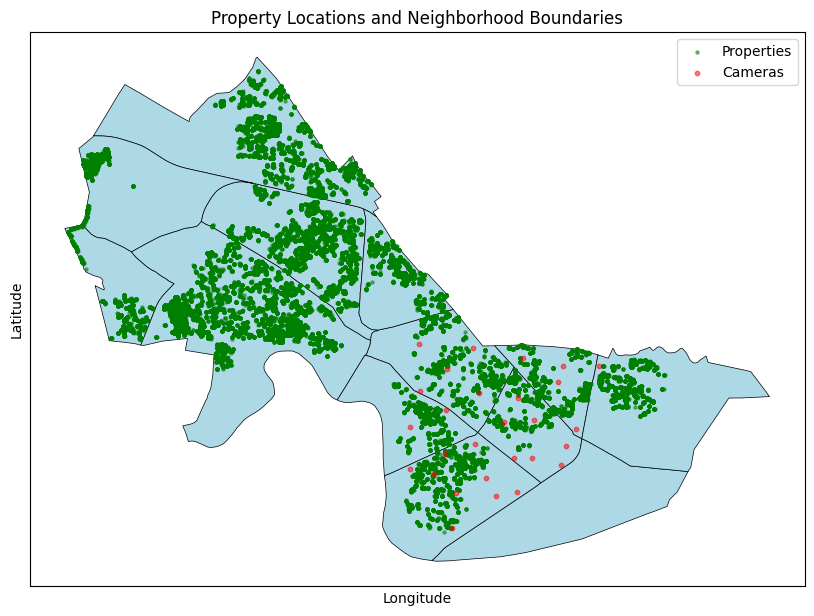

In [5]:
# Graph data as a sanity check
plot_test_map()

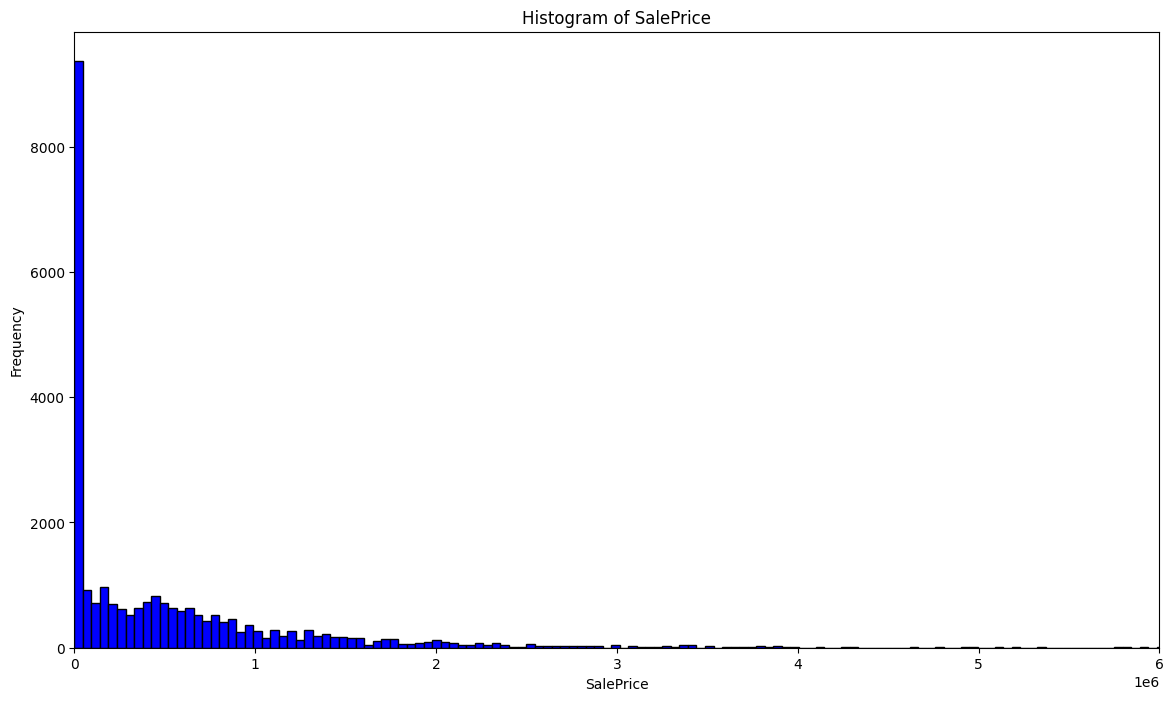

In [6]:
# we have a problem, in that our SalePrice data has confounding variables:
plot_raw_frequency(assessment_items,'SalePrice',max_val = 6_000_000) # this omits a few tiny outliers from the graph, I will need to address those later

we seem to have some combination of trash data and good data.

we can see this in the plot skewing heavily towards $0 sale price.
This obviously doesn't make sense, as houses should sell for fairly large amounts of money.

after some research, it seems low sale prices are common in real estate.
A price of 0 or some other arbitrarily low value, could indicate:
1. a missing value,
2. low sale price between friends, family, etc.
3. cash offers that went unreported
4. a property that is in some way actually worth essentially nothing
5. any number of other odd edgecases

In [7]:
# we need to know if trash data  always sells for $0, or if there are more small values that appear
# to do this, we check the sorted list of price frequencies:
print(create_test_frequency_sorted(assessment_items,'SalePrice'))

[(1.0, 4755), (0.0, 2126), (100.0, 1320), (10.0, 555), (150000.0, 133), (1300000.0, 125), (1100000.0, 117), (1200000.0, 111), (850000.0, 95), (450000.0, 93), (160000.0, 93), (650000.0, 92), (550000.0, 91), (600000.0, 87), (460000.0, 85), (475000.0, 84), (1450000.0, 82), (485000.0, 81), (280000.0, 79), (700000.0, 75), (1150000.0, 74), (225000.0, 73), (895000.0, 72), (400000.0, 70), (370000.0, 69), (840000.0, 68), (900000.0, 68), (1600000.0, 65), (430000.0, 64), (640000.0, 63), (1000000.0, 63), (950000.0, 63), (210000.0, 61), (570000.0, 61), (510000.0, 59), (190000.0, 58), (1750000.0, 58), (785000.0, 58), (480000.0, 57), (385000.0, 57), (975000.0, 57), (130000.0, 57), (810000.0, 56), (1550000.0, 56), (565000.0, 55), (1350000.0, 55), (265000.0, 54), (155000.0, 54), (530000.0, 54), (605000.0, 54), (120000.0, 53), (725000.0, 53), (90000.0, 53), (410000.0, 53), (275000.0, 53), (185000.0, 52), (1850000.0, 52), (775000.0, 51), (220000.0, 51), (635000.0, 50), (250000.0, 49), (350000.0, 48), (23

Looks like there are many small values that are problematic, unfortunately.
1. A naive plan would simply remove overly small values, but the cutoff point seems arbitrary.
2. Instead, we could consider using statistical techniques like gaussian mixture models to identify the distribution we care about in the data. However, this may not work well on these trashy small values since the distribution is extremely jagged -- people chose arbitrary prices, so they tended to choose "human-y" numbers, such as 0,1,10,100... meaning the data (may) not fit nicely into a gaussian distribution.
3. Alternatively, and most promisingly, we can compute each home's most recent  sale price as a percentage of it's assessed value. Hopefully this would yeild more distinct distributions. We could then remove observations from the dataset if their standard deviation w/r/t to the %age-of-assessed-value-distribution.
4. The final option would  be to make use of the apparently small selection of human-chosen arbitrary values to manually remove a good section of the bad data directly. This is the path we pursue for now, though we will cycle back to  both numbers 2 and 3 I expect.

In [8]:
# we name variable copies with the number of the strategy we are currently working on, from the list above
assessment_items_4 = assessment_items.copy(deep=True)
# calculate sale price as a percentage of the  assessed value of the  property
assessment_items_4 = create_calculate_percentage_of_assessed_value(assessment_items_4)

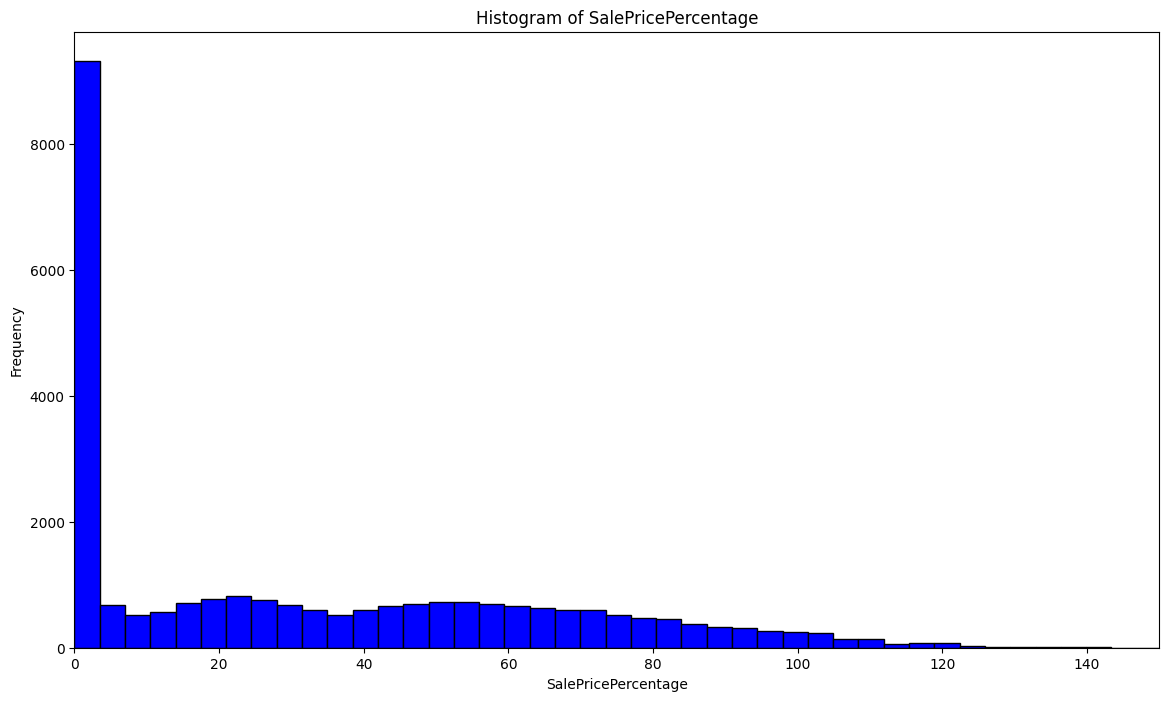

In [9]:
plot_raw_frequency(assessment_items_4,'SalePricePercentage',200,max_val=150)

Looks like the distributions *are* a bit cleaner, though certainly far from perfect still. The most interesting thing here though is that there seem to be ~3 significant peaks in the graph. Conceptually, each of these should correspond to a different "sort" of sale. The clear descriptor of these three categories is that one is essentially free, one is about 5-30% of a "reasonable" sale price, and the final distribution seems to represent closer to "fair price". Intuitively, we can think about the sales as *gift* (the essentially free homes), *subsidized* (charging family only what they can pay, ie), and *market* prices.

Interestingly though, even the final "fairly priced" distribution is significantly below the assessed value; the peak seems to be at around 55% of the assessed value of the home. This is especially odd given that the common wisdom is that assessed home values tend to lag behind realized sale prices.

Two primary answers arise:

1. Naively we might think this is simply a result of economic turbulence -- it is true that recent downturns in the residential market since its peak in early 2022 *may* have skewed the data away from assessment calculations (note that it is less likely to involve historic downturns since these should've eventually been accomodated for by the assessed value calculations of subsequent years. similarly it theoretically should have been averaged out with corresponding  upturns. Finally, observe that there was no significant downturn in the US economy or residential market during the studied time range except for the Covid and Ukranian war downturns of 2020 and 2022, both "recent".) Since it seems like this is ultimately not likely to be a hugely important factor in explaining the skew we are observing, we turn to our second option.
2. Consider that home prices did rise over the studied time period (demonstrated below). This means that theoretically, the housing price distribution each year will shift right along the x-axis with each subsequent year (This is true over tiny time intervals too, but the interval needs to be large enough to contain a meaningful quantity of data, and the shift in the  distribution would be correspondingly tiny). This would theoretically lead to a visibly lengthened distribution with a left skew, as the distributions would start at their lowest mean (farthest left) and progress to the right.

The second cause seems much more likely to me, so let's experimentally demonstrate some of our conclusions:

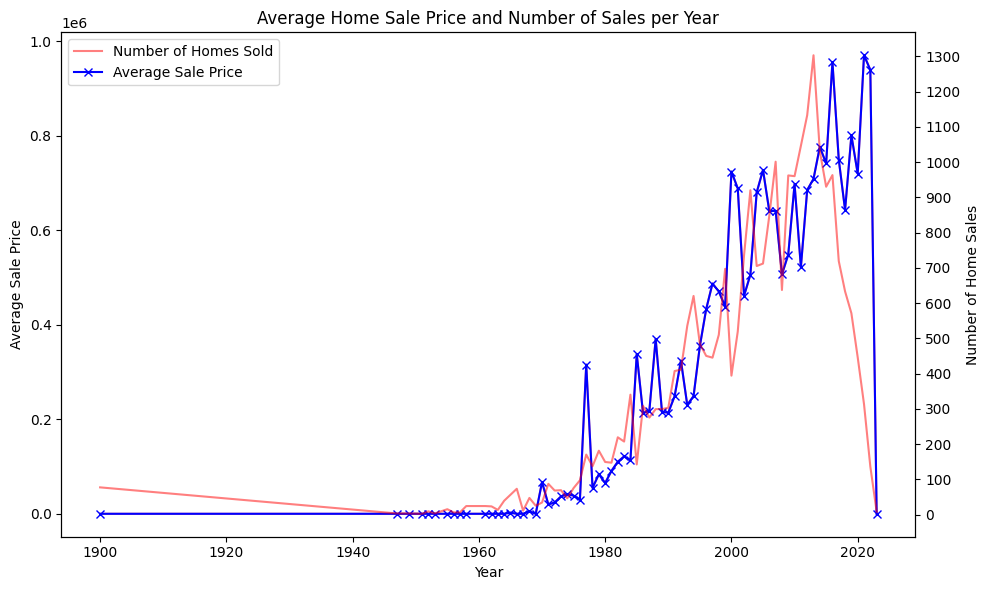

In [10]:
# first, let's check that the price of homes in the area did significantly increase over the studied time period:
plot_create_historic_sales(assessment_items_4)

Looks like we were right that home sale price has increased over time -- the  average sale price in 2021/2022 is the highest peak in the graph and directly corresponds with the Covid recovery, as mentioned above.

That being said, there are a number of surprising things about this data.
1. Firstly it dates all the way back to 1900, even though this dataset is only meant to cover 2016 to 2024. This makes sense: since this is an assessment dataset, we know that the most recent home assessment should be in the correct date range. Meanwhile, the most recent sale date doesn't matter; it is only guaranteed to be an arbitrary point in time before the assessment. Therefore, the data points at 1900 could have plausibly sold in that year. However, a more obvious explanation would be that this is simply the oldest date that can be entered. If the home has never been sold, was sold most recently *before* 1900, or the sale data is unknown, it would make sense to simply put down the oldest date allowable. This would explain why there are so many homes listed for this sale date (77 home sales), while the nearest year with data in 1947 had only 3 sales. This also explains the large time gap till 1947 (the next year with sale data).
2. The next surprising thing in this graph is the noise: since this is an average of many datapoints over time, one would expect a fairly smooth curve. Instead, there are frequent noisy spikes, and  the average home value plunges to 0 in 2023 and ends there (it seems no homes were sold in 2024 before assessment, and only 8 were sold in 2023 -- each for $0).

Originally I hypothesized that the noise was being caused by lower sale numbers those years, but after adding the number of homes sold to the graph as well I realized that these fluctuations seem to be market based. Since about the year 2000, each major peak in average home price comes at approximately the same time as a minimum is reached by number of home sales. This corresponds to the idea of scarcity driving up prices for homes, when fewer are on the market. This is a surpise to me, as I did not expect small scale supply/demand relationships to be so significant over such short time periods.

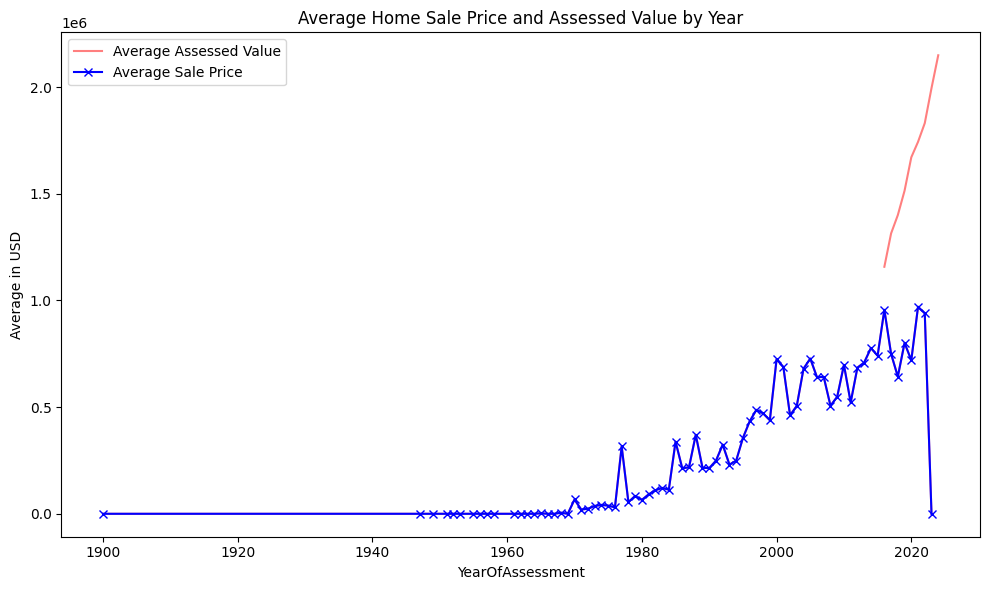

In [11]:
# let's investigate what our assessment data looks like
plot_create_historic_values(assessment_items_4)

[(165000.0, 16), (192000.0, 13), (185000.0, 12), (170000.0, 12), (180000.0, 12), (176000.0, 12), (240000.0, 9), (875700.0, 8), (1230900.0, 8), (986800.0, 8), (852100.0, 8), (900600.0, 7), (878400.0, 7), (753300.0, 7), (913900.0, 7), (852300.0, 7), (886000.0, 7), (1301100.0, 7), (917600.0, 7), (906700.0, 7), (751200.0, 7), (675100.0, 7), (843800.0, 7), (786300.0, 7), (970200.0, 7), (995000.0, 7), (869800.0, 6), (920900.0, 6), (315000.0, 6), (950100.0, 6), (922300.0, 6), (1003200.0, 6), (923000.0, 6), (774600.0, 6), (955700.0, 6), (960800.0, 6), (1431300.0, 6), (982700.0, 6), (1167200.0, 6), (1023000.0, 6), (899000.0, 6), (1082700.0, 6), (1113800.0, 6), (1569100.0, 6), (1534700.0, 6), (1141800.0, 6), (1012600.0, 6), (902300.0, 6), (747600.0, 6), (955600.0, 6), (1188700.0, 6), (983600.0, 6), (747500.0, 6), (1074200.0, 6), (883700.0, 6), (904900.0, 6), (1344800.0, 6), (902400.0, 6), (1234900.0, 6), (1031300.0, 6), (946300.0, 6), (1388700.0, 6), (763000.0, 6), (881700.0, 6), (917500.0, 6), 

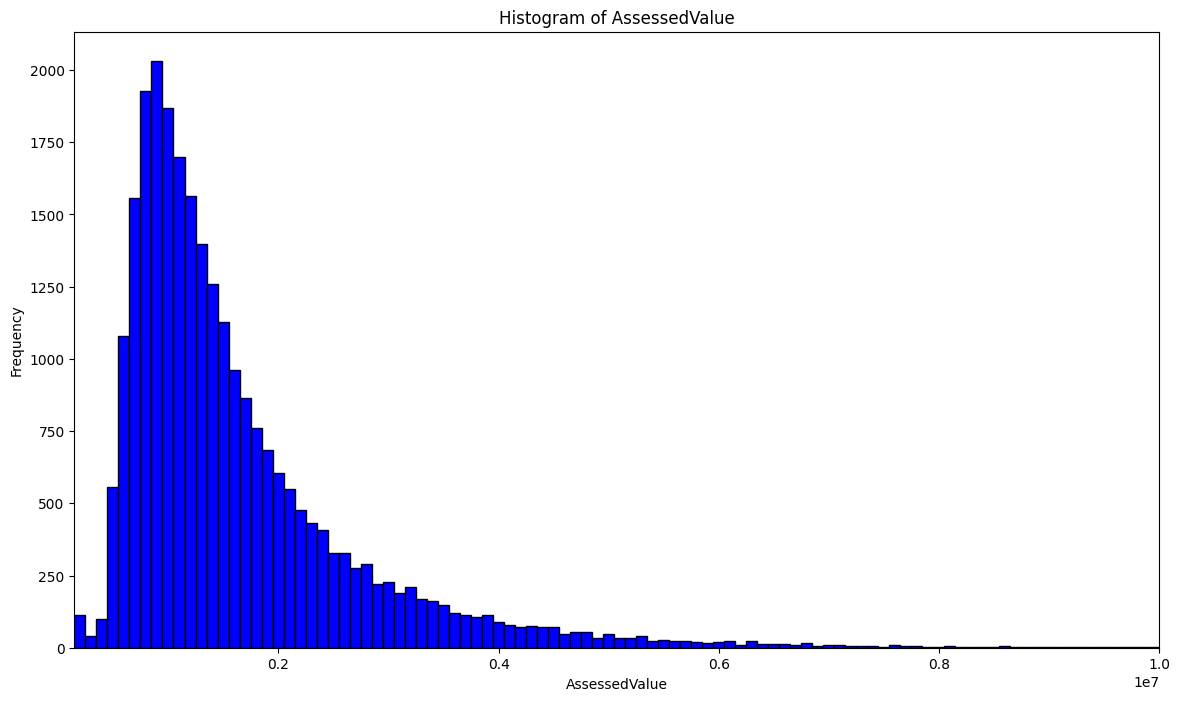

In [12]:
# what does the  distribution look like?
print(a:=create_test_frequency_sorted(assessment_items_4,'AssessedValue'))
plot_raw_frequency(assessment_items_4,'AssessedValue',max_val = 10_000_000)

[(165000.0, 16), (192000.0, 13), (185000.0, 12), (170000.0, 12), (180000.0, 12), (176000.0, 12), (151000.0, 5), (166300.0, 3), (155000.0, 3), (195100.0, 1), (183000.0, 1), (148000.0, 1)]


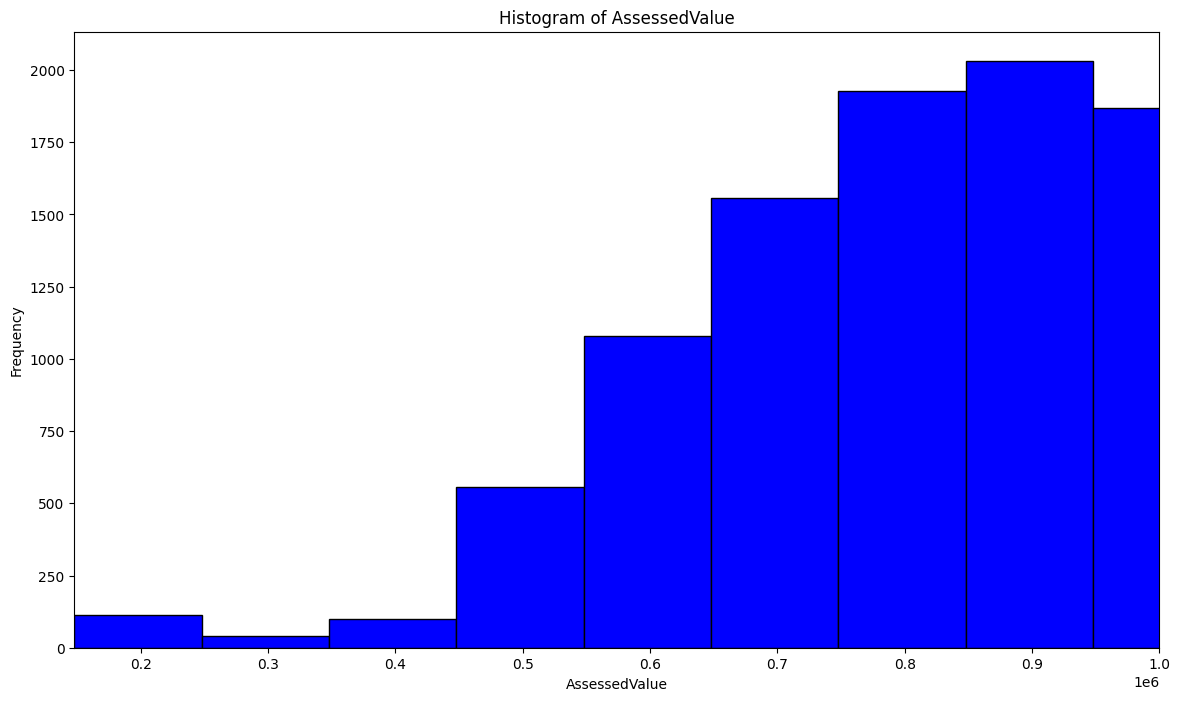

In [13]:
# and a closer look at the distribution's area near 0:
print(create_test_frequency_sorted(assessment_items_4[assessment_items_4['AssessedValue']<200_000],'AssessedValue'))
plot_raw_frequency(assessment_items_4,'AssessedValue',max_val = 1_000_000)

A few important observations on the assessed value:
- Average assessed value per year seems wildly over inflated for the time range in this data, though I do not necessarily anticipate this impacting further analysis, as we will not directly use assessment value for our results.
- There appears to be a near 0 bump in this dataset as well, but on further inspection it seems that the lowest value for an assessed property in the modern time range is $148,000, which seems authentic. For this we conclude the assessment data needs no further cleaning.
- The time range we have assessment values for does not line up well with our sale data. This problem will need to be resolved by the next groups to work on this project, by adding other publicly available datasets to construct a more comprehensive view of the data. Care must be taken during this process to ensure that properties are not double counted and that the assessment and sale price share the same time window. The way to do this is to limit the sale data to only include the sales listed in a a given dataset in the time frame between the sale date of the last sold property from the previous dataset to the last sold property of this dataset, discrading 0s and other arbitrarily low values along the way. For us this means we will only analyze 2015-2022 in full. Future work will fill in the rest of the date range.

For us, however, it is time to validate the most important of our conjectures from the earlier distribution analysis.

Plotting SalePricePercentage for the year: 2015


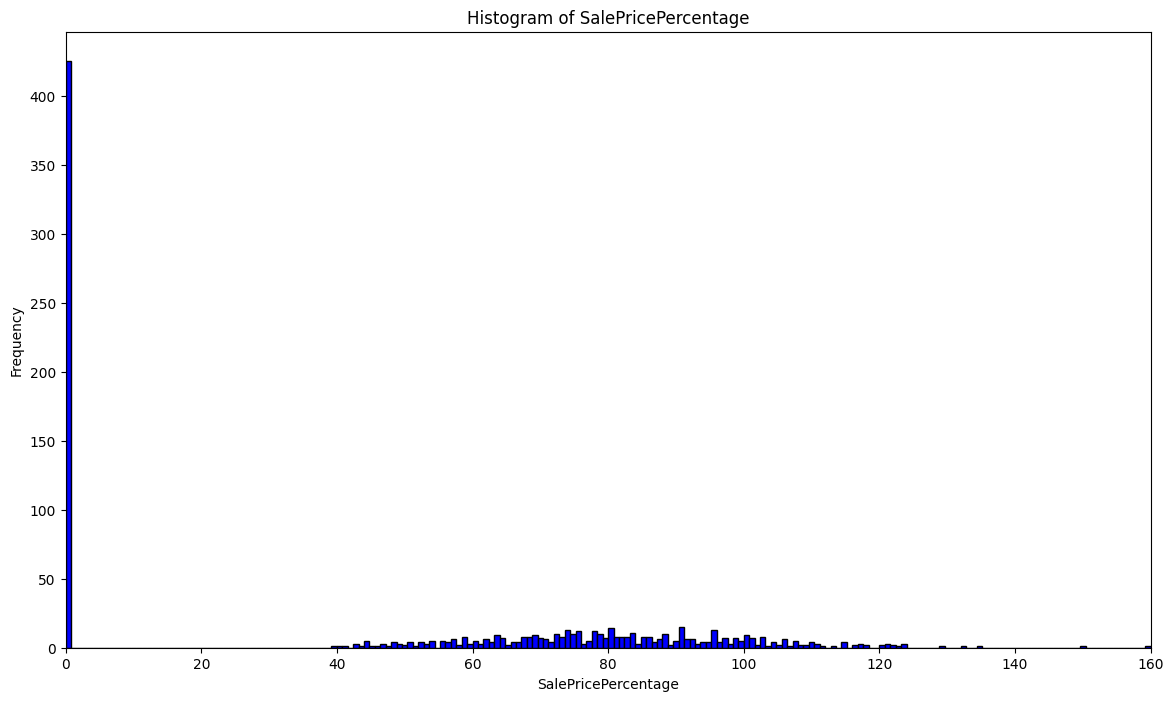

Plotting SalePricePercentage for the year: 2016


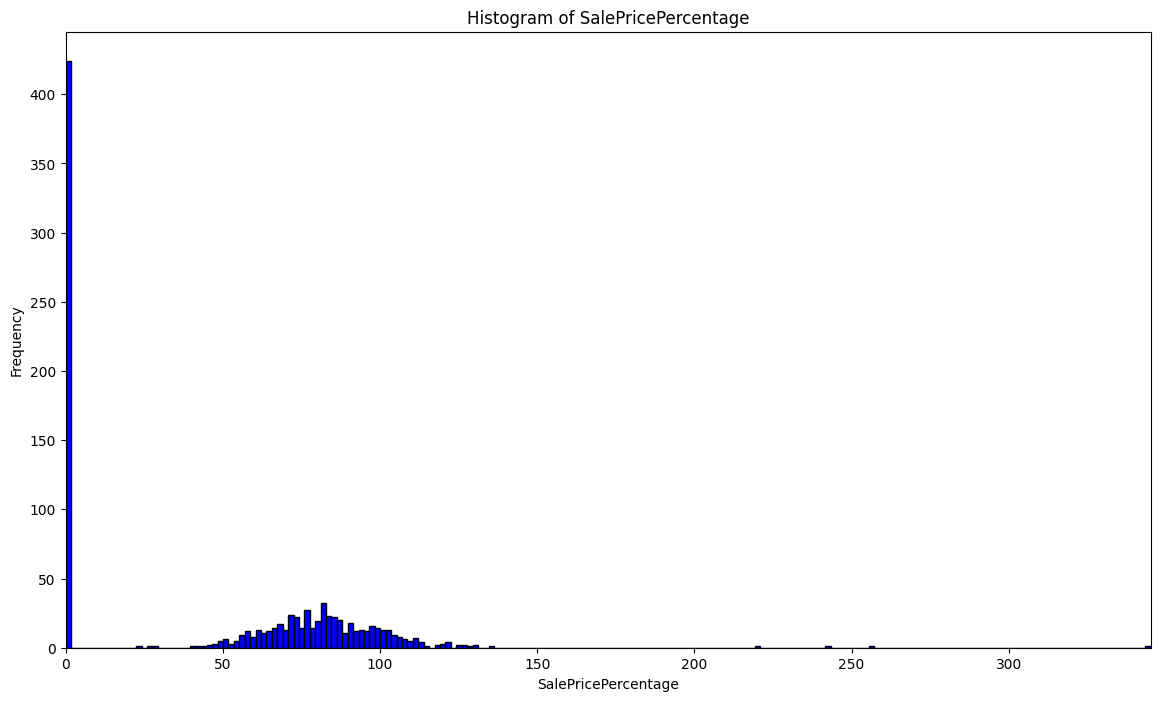

Plotting SalePricePercentage for the year: 2017


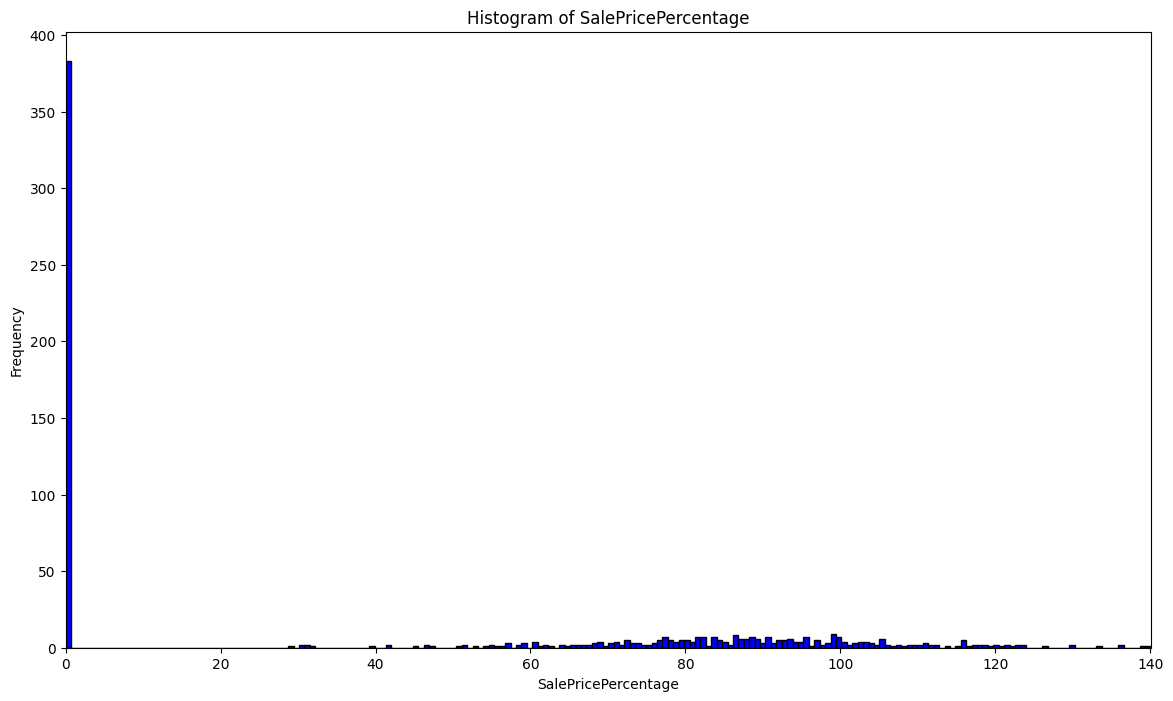

Plotting SalePricePercentage for the year: 2018


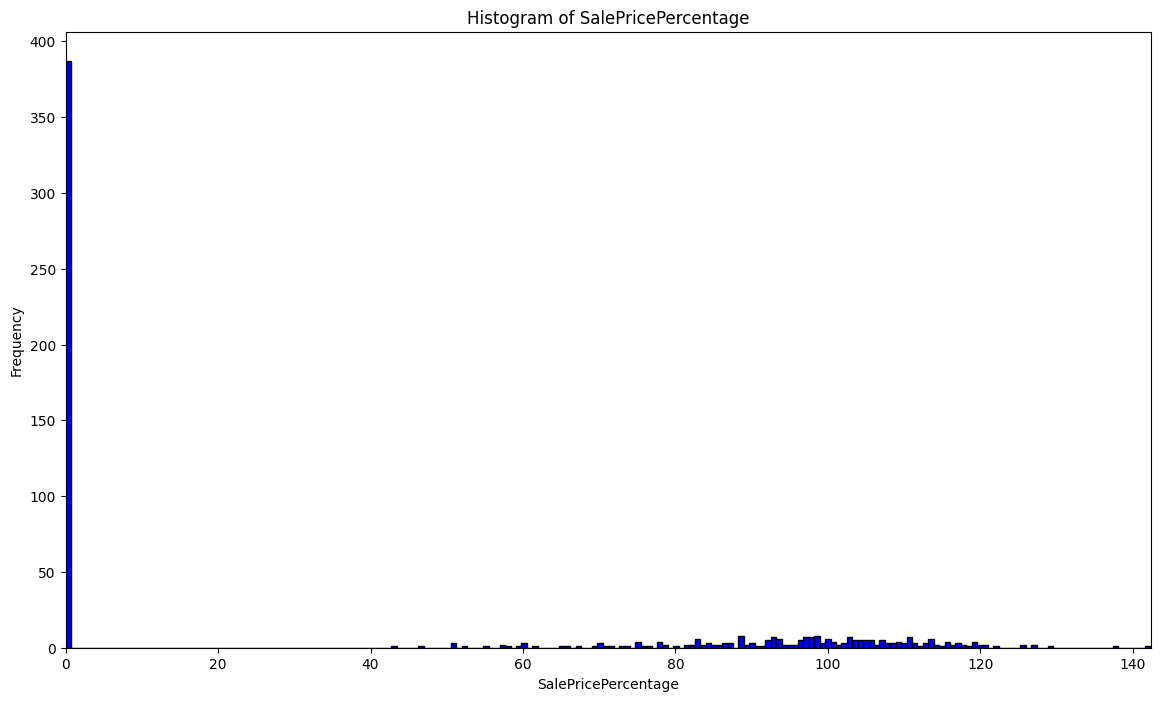

Plotting SalePricePercentage for the year: 2019


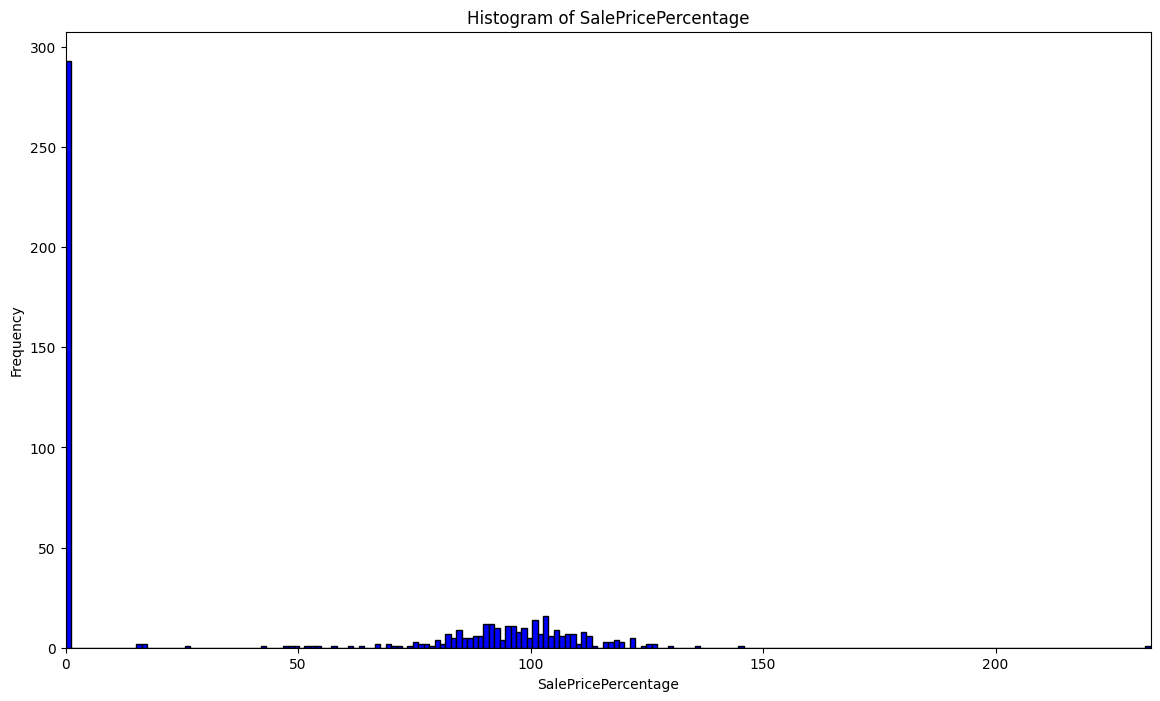

Plotting SalePricePercentage for the year: 2020


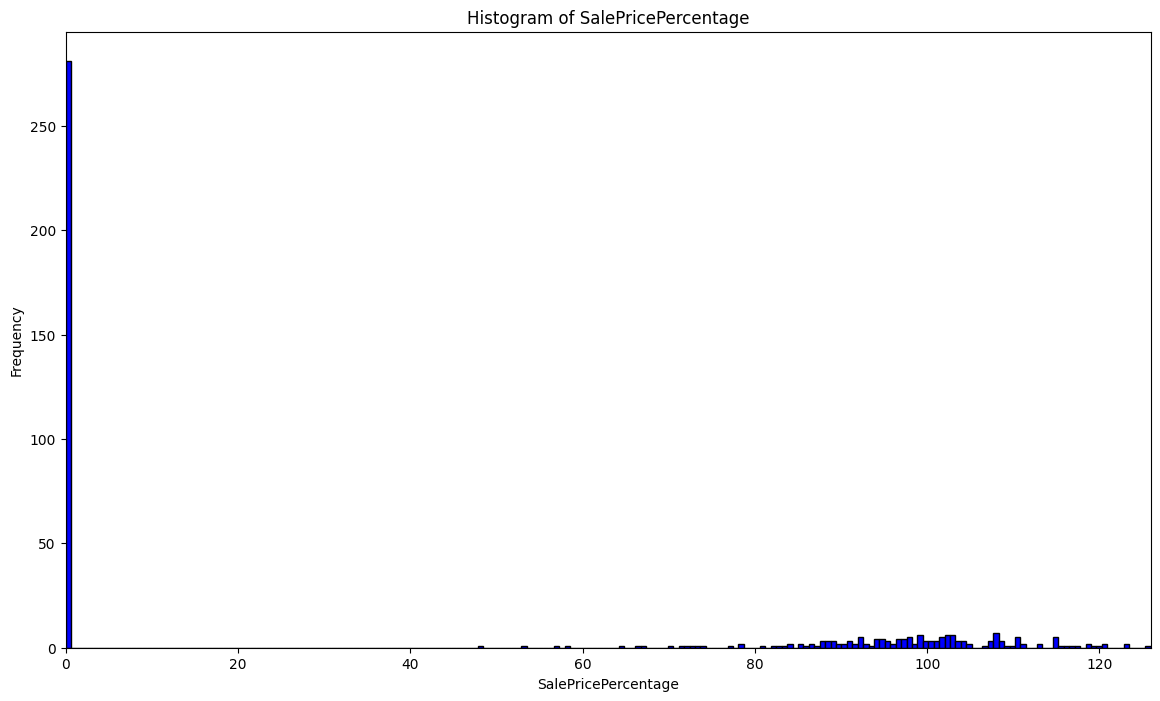

Plotting SalePricePercentage for the year: 2021


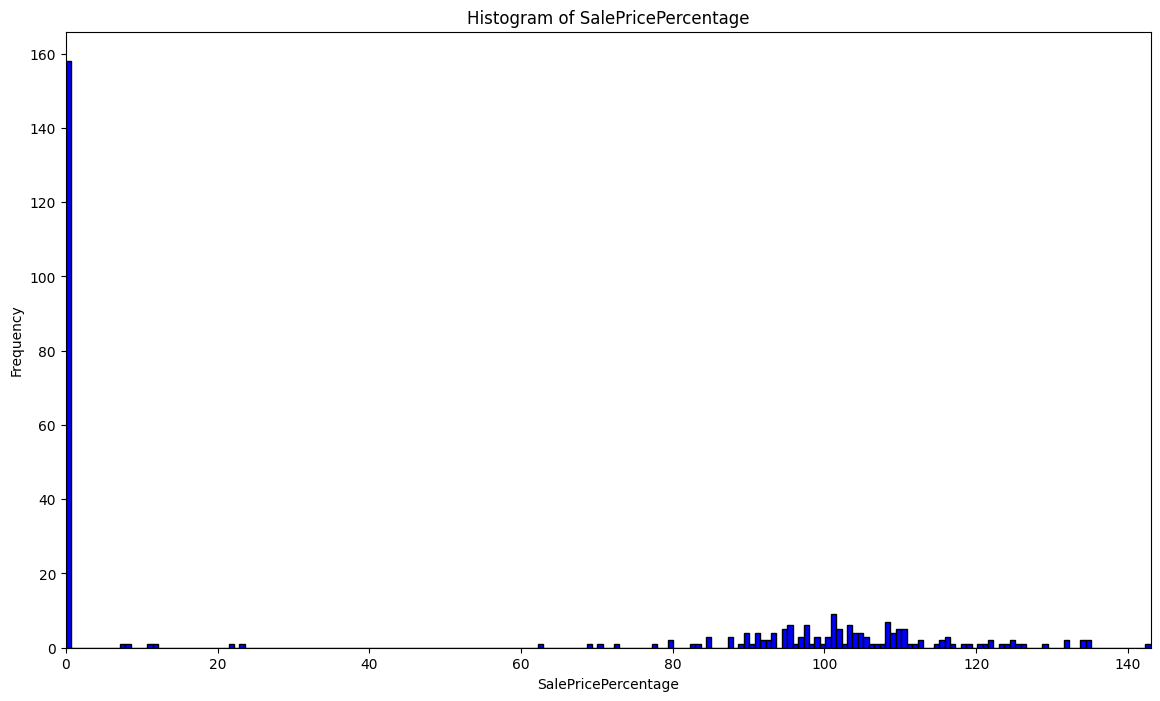

Plotting SalePricePercentage for the year: 2022


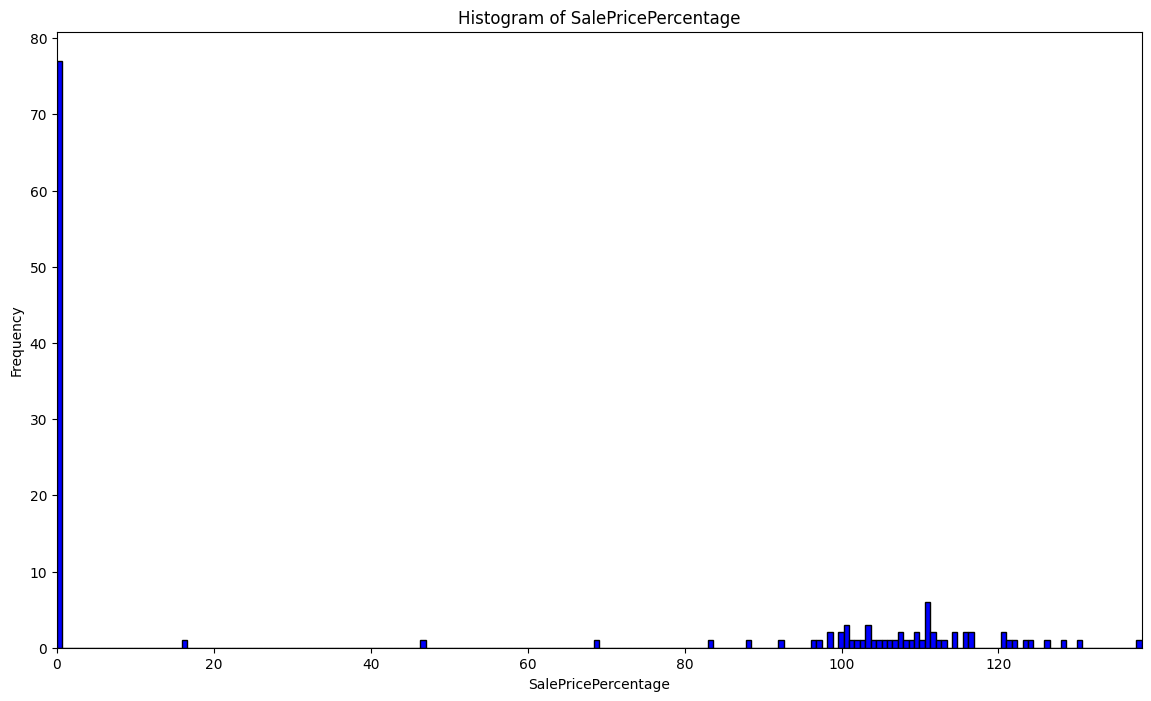

In [14]:
plot_distribution_by_year(assessment_items_4,'SalePricePercentage',min_val=2014,max_val=2023) # date range is [2015-2022] inclusive

It looks like we were right about the distributions being cleaner when we control for time! There seems to be a very clean division at the very least between the near-zero bar and the rest of the data. Let's start by reducing the range of dates to 2015-2022 as mentioned:

In [15]:
# lets work with a new assessment items copy
items = assessment_items.copy(deep = True)
# add back the SalePricePercetage column
items = create_calculate_percentage_of_assessed_value(items)
# change SaleDate to Year
items['Year'] = pd.to_datetime(items['SaleDate']).dt.year
items = items.drop(columns=['SaleDate'])
# filter for our date range
items = items[items['Year']>2014]
items = items[items['Year']<2023]
print(items.head())

    PID  GISID  YearOfAssessment  AssessedValue  SalePrice  \
3   701  17-54              2021       969800.0   980000.0   
4   702  17-55              2021      1018200.0      100.0   
16  891  21-39              2021      1739100.0  1885000.0   
27  941  22-25              2021       850600.0        1.0   
34  967  22-70              2021       797100.0        1.0   

                          geometry                   Neighborhood_GlobalID  \
3   POINT (769343.345 2959224.195)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
4   POINT (769343.345 2959224.195)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
16  POINT (769713.959 2960793.065)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
27  POINT (769144.711 2961154.697)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
34  POINT (768902.051 2961044.180)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   

    SalePricePercentage  Year  
3            101.051763  2018  
4              0.009821  2018  
16           108.389397  2019  
27             0.000118  2019 

Plotting SalePrice for the year: 2015


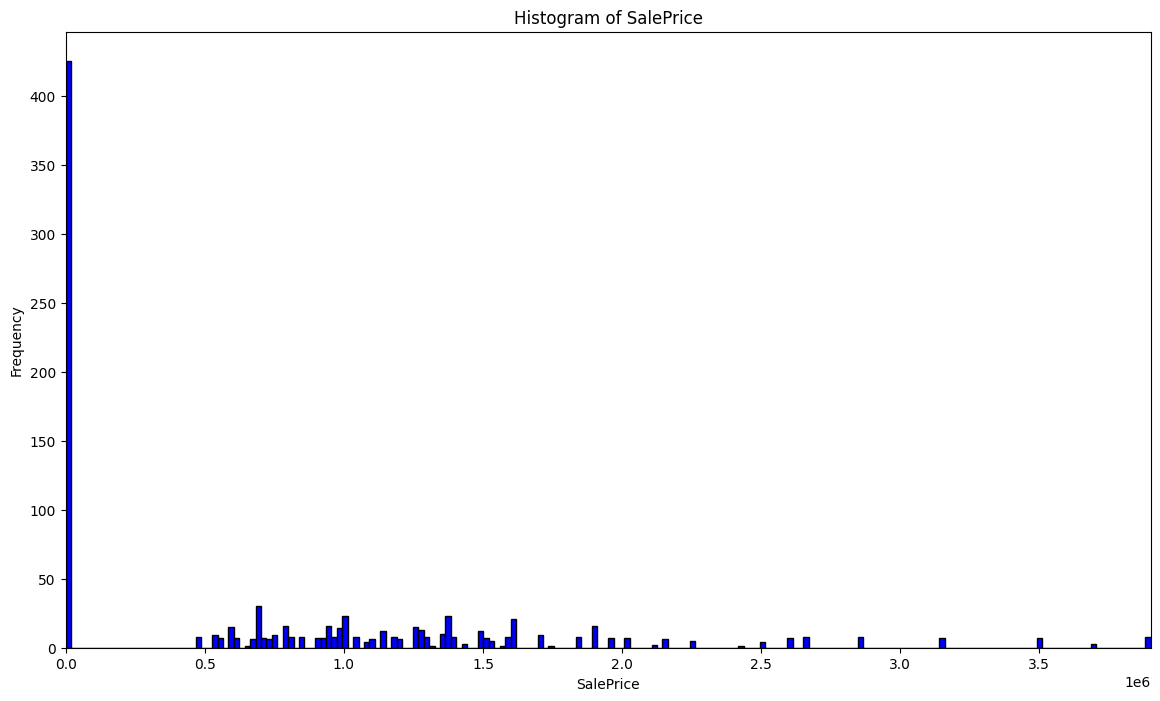

Plotting SalePrice for the year: 2016


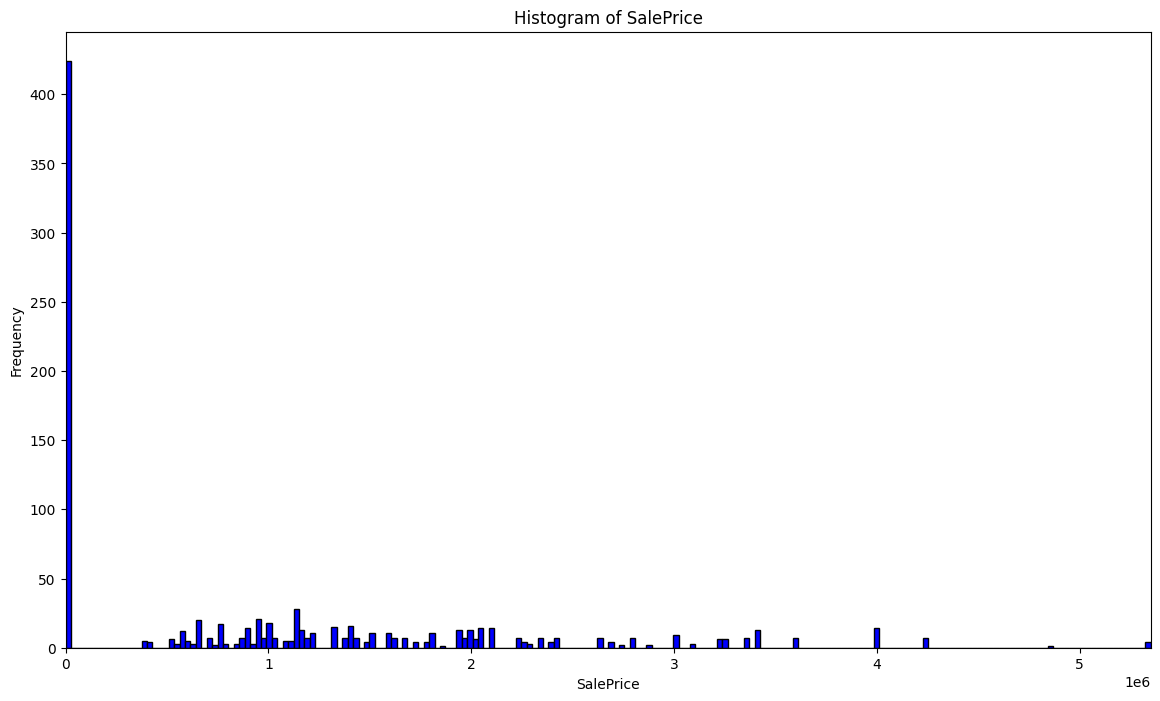

Plotting SalePrice for the year: 2017


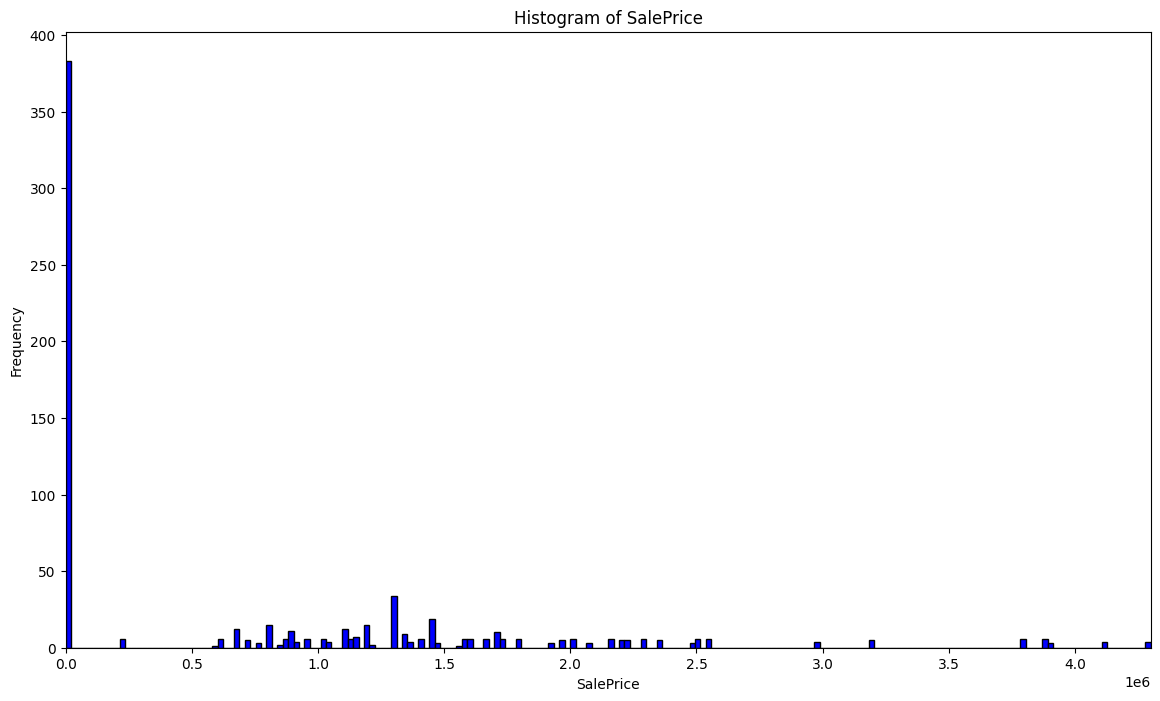

Plotting SalePrice for the year: 2018


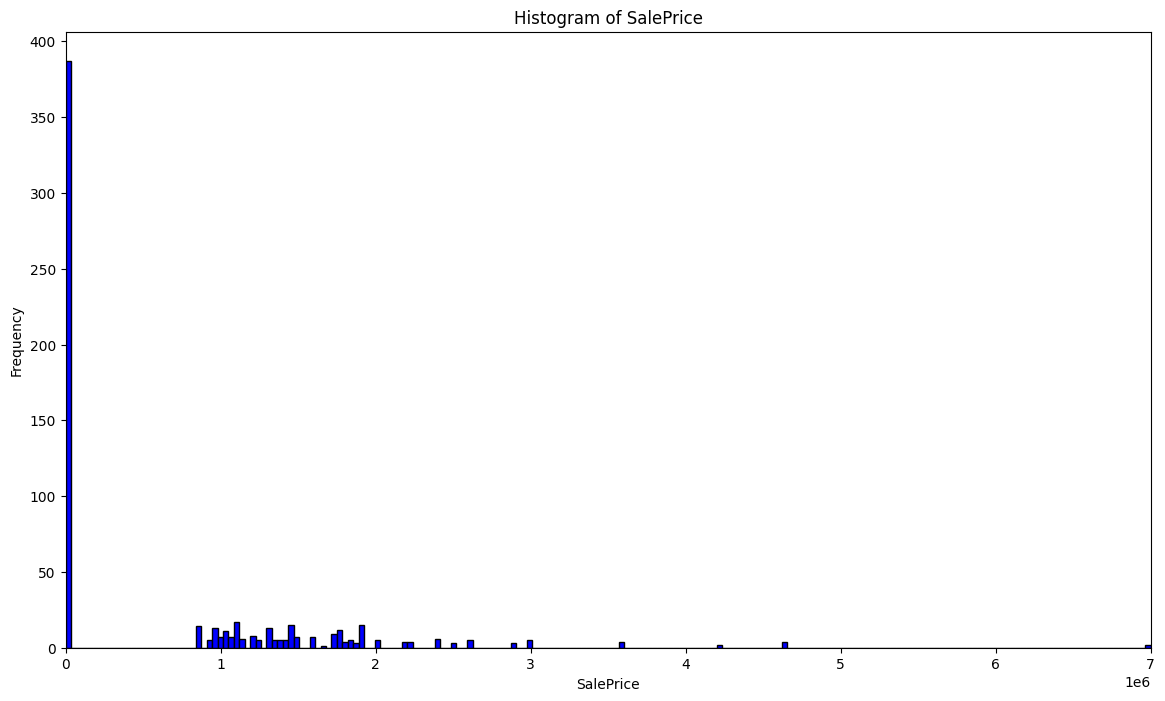

Plotting SalePrice for the year: 2019


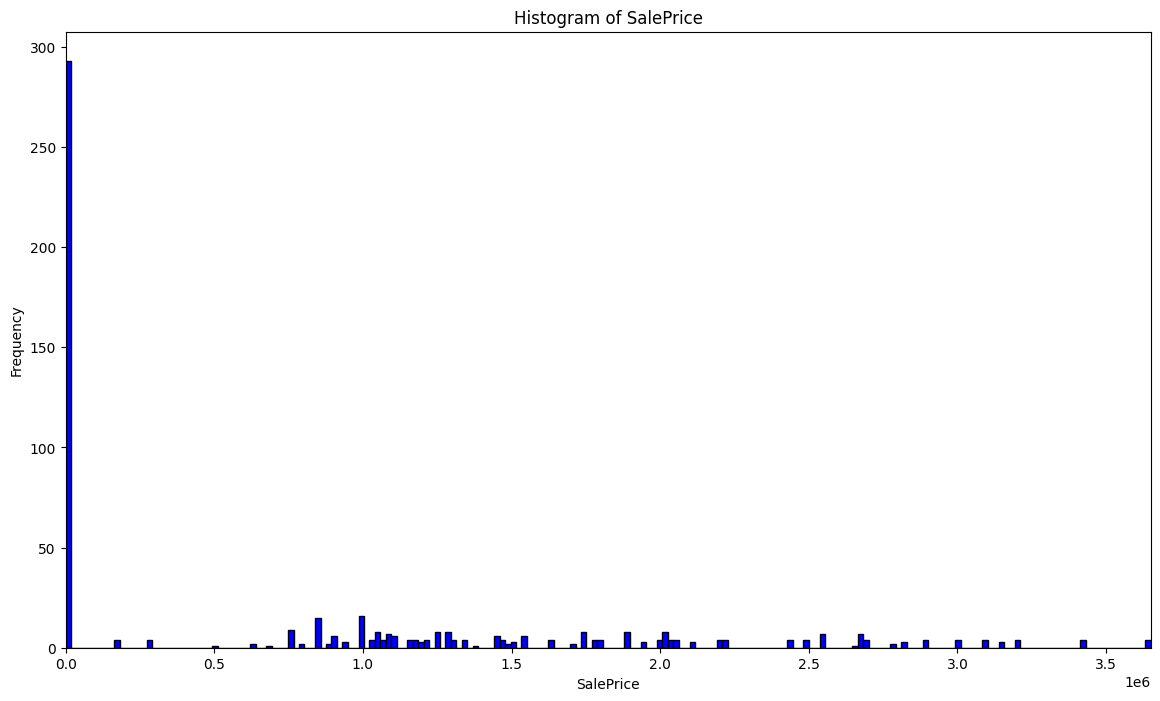

Plotting SalePrice for the year: 2020


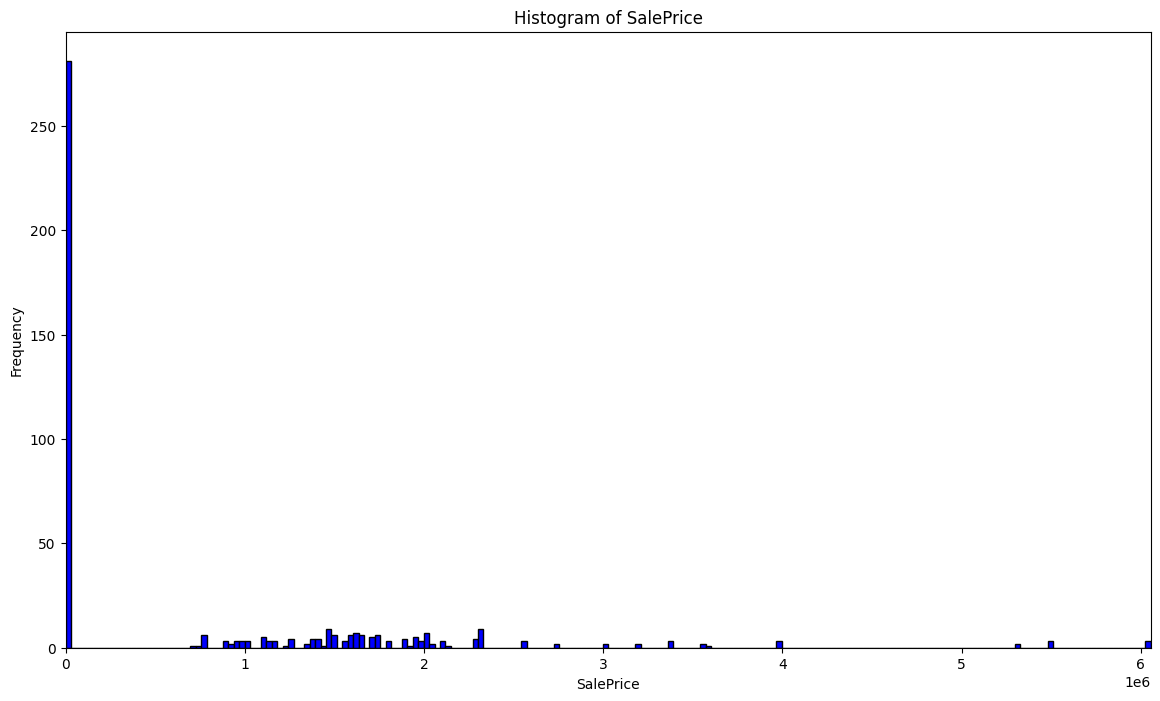

Plotting SalePrice for the year: 2021


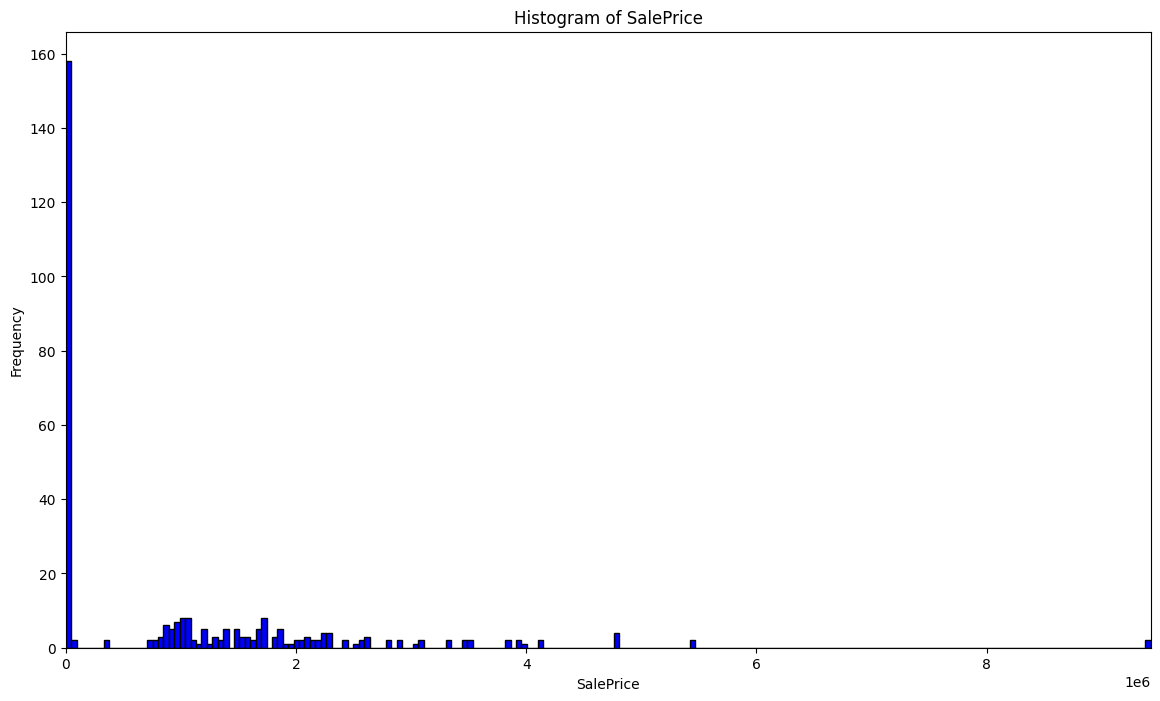

Plotting SalePrice for the year: 2022


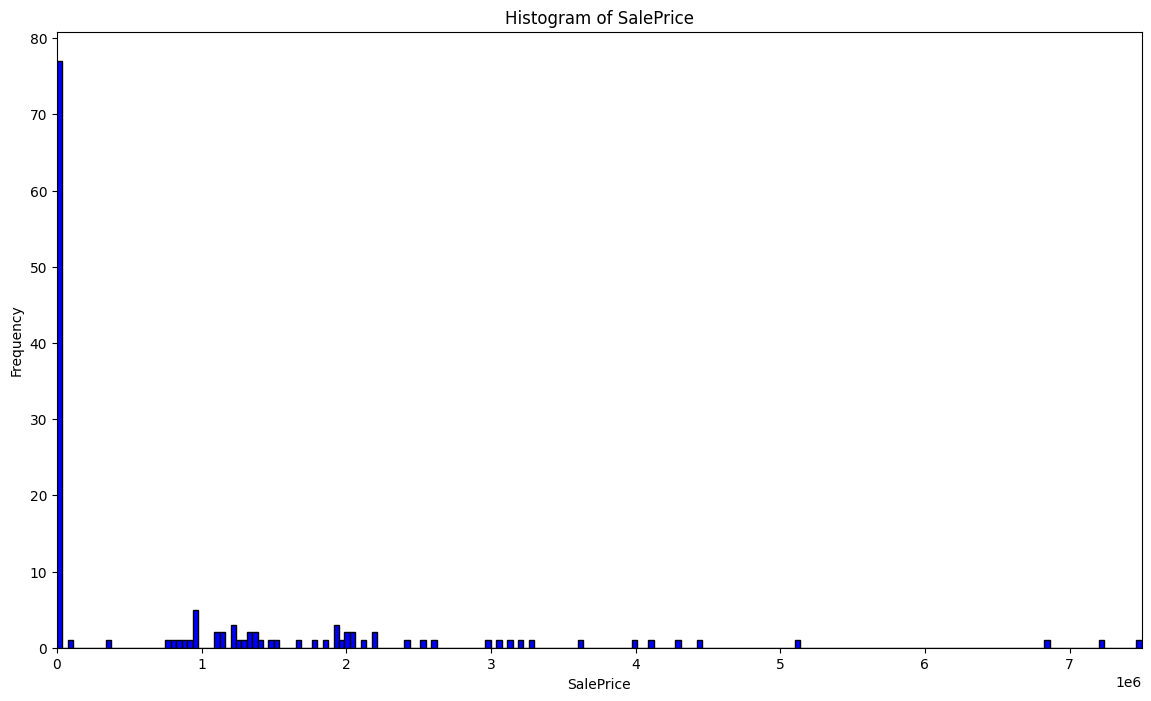

In [16]:
# inspect the sale price distributions by year as well
plot_distribution_by_year(items,'SalePrice')

Plotting SalePricePercentage for the year: 2015


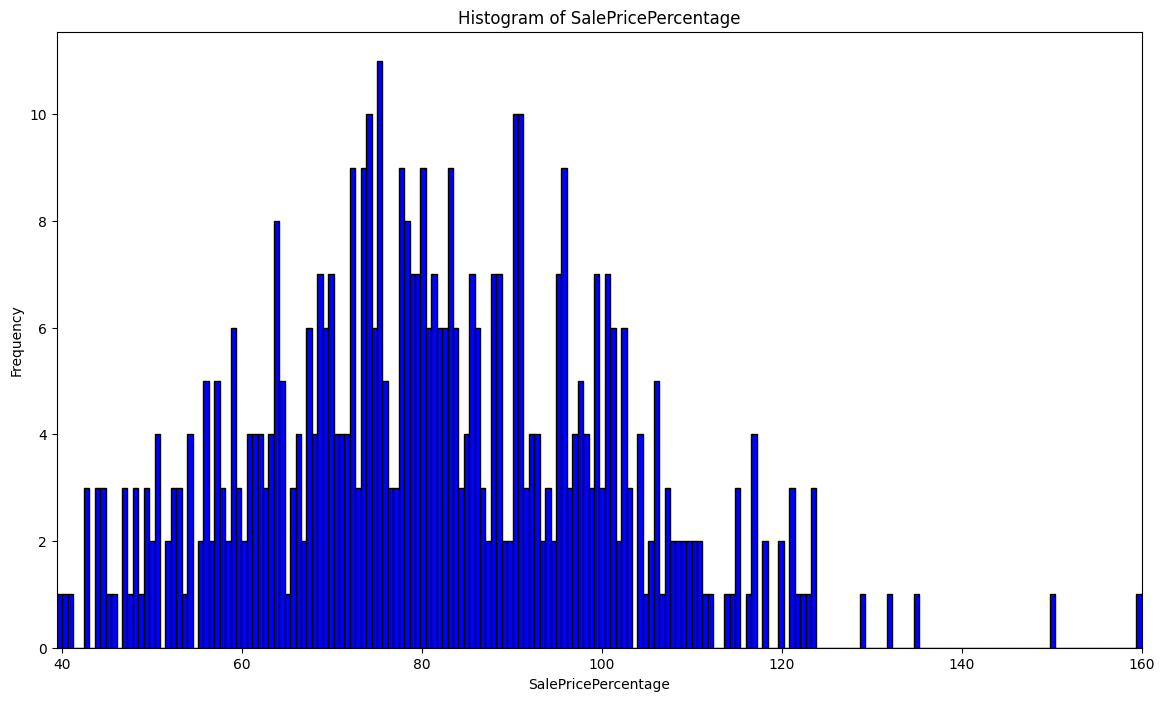

Plotting SalePricePercentage for the year: 2016


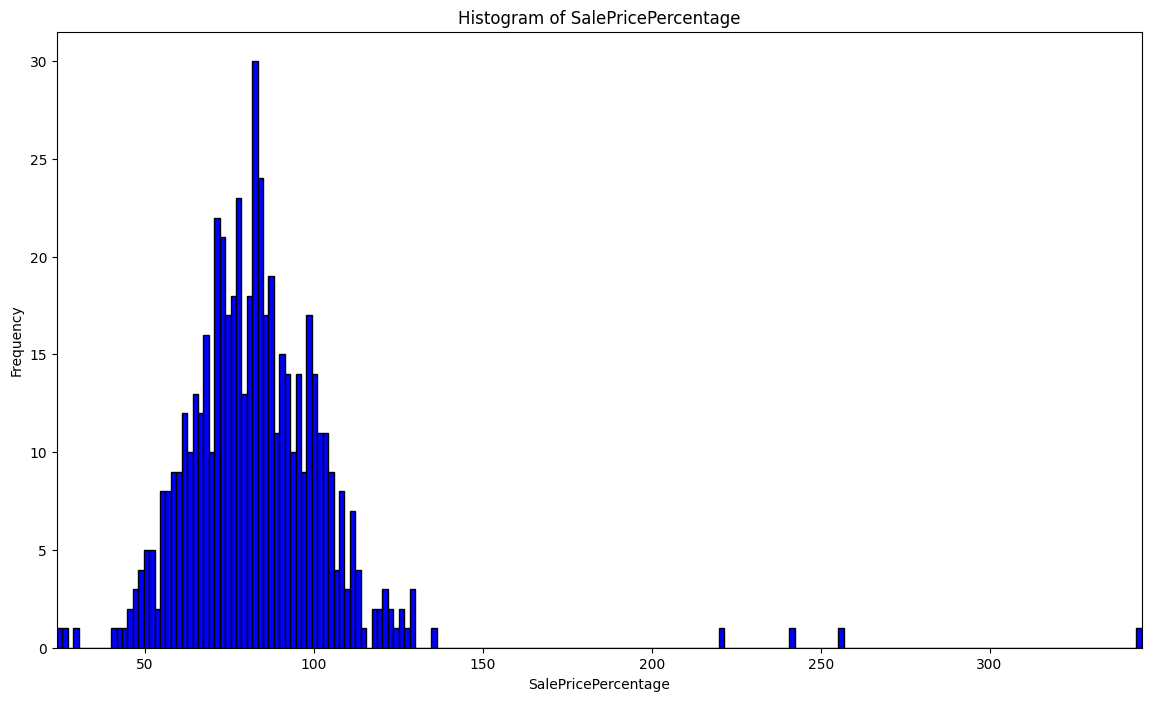

Plotting SalePricePercentage for the year: 2017


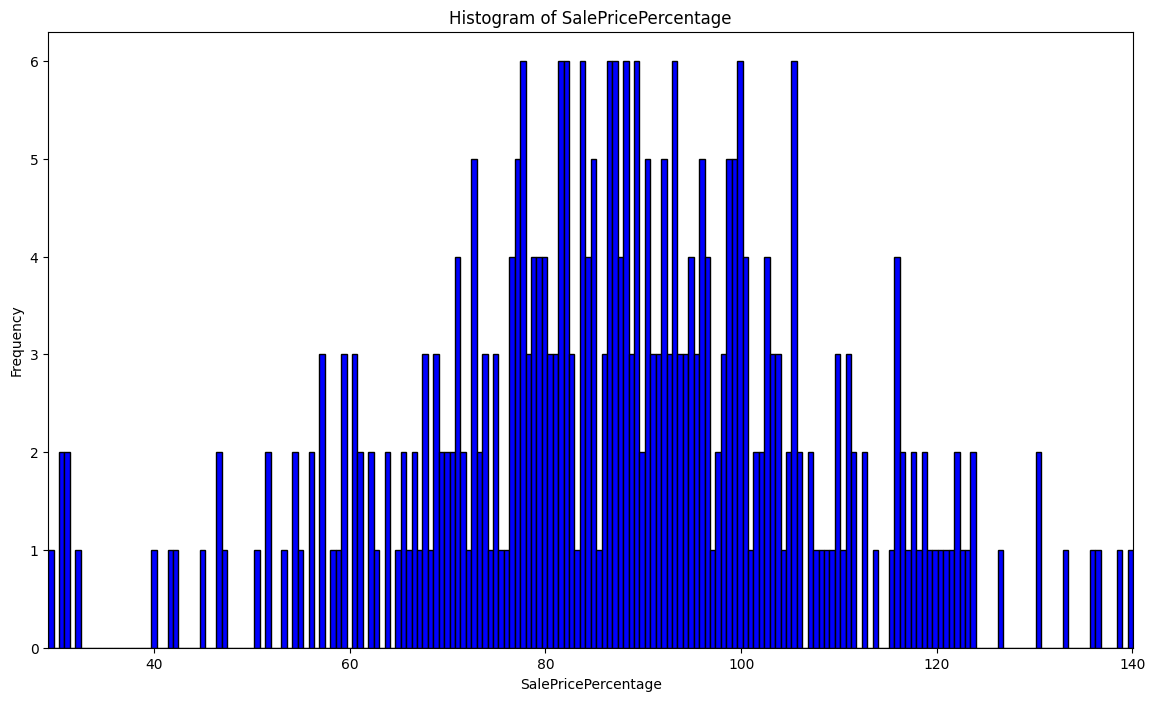

Plotting SalePricePercentage for the year: 2018


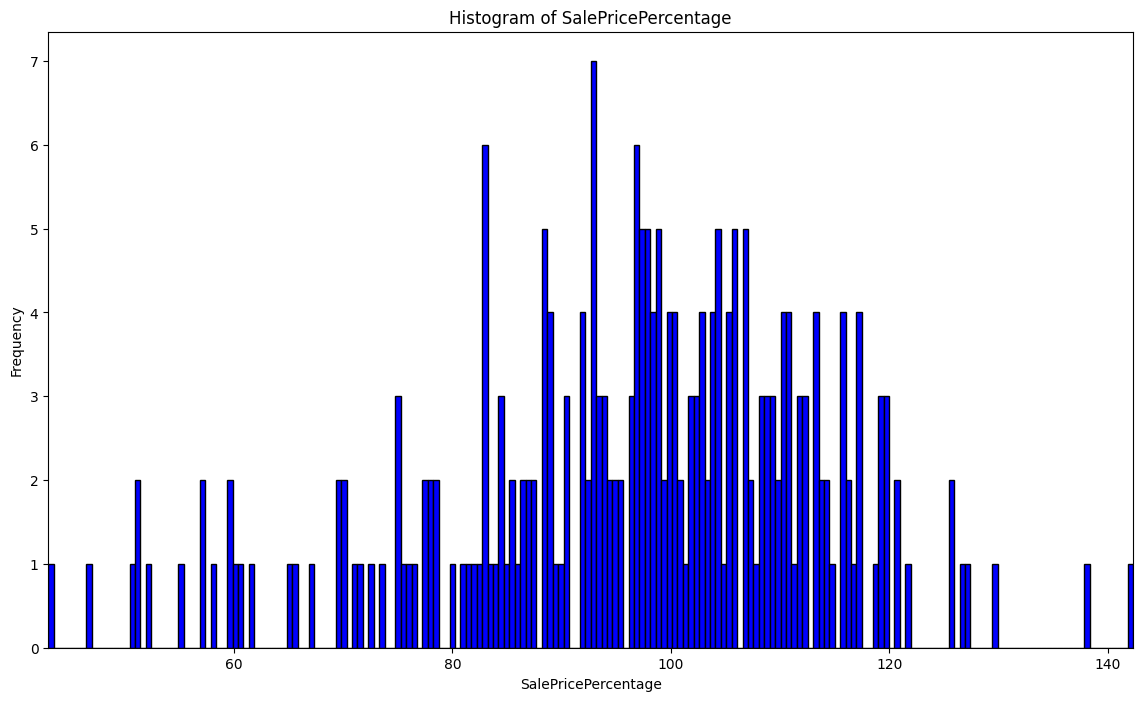

Plotting SalePricePercentage for the year: 2019


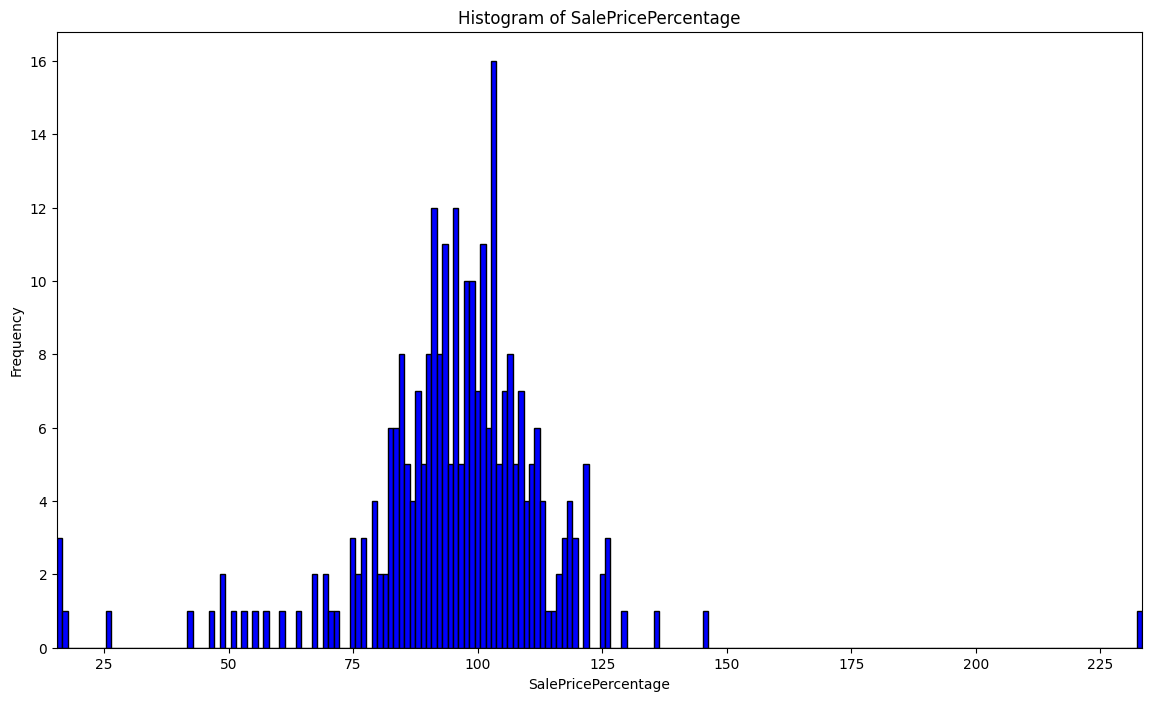

Plotting SalePricePercentage for the year: 2020


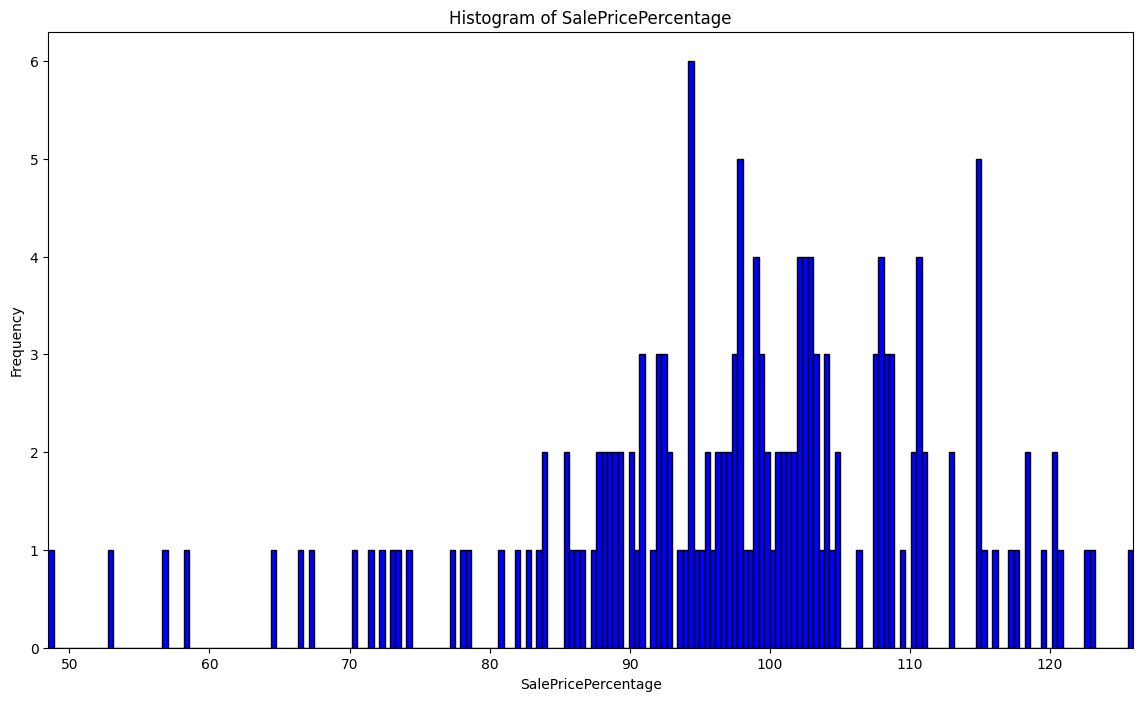

Plotting SalePricePercentage for the year: 2021


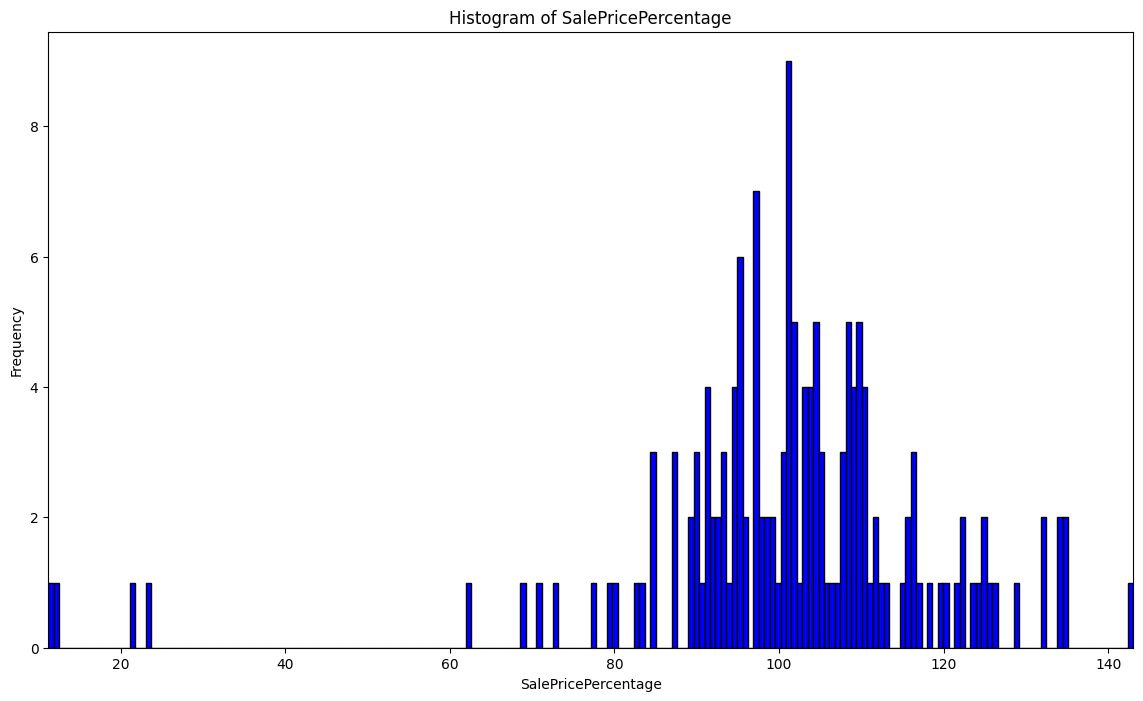

Plotting SalePricePercentage for the year: 2022


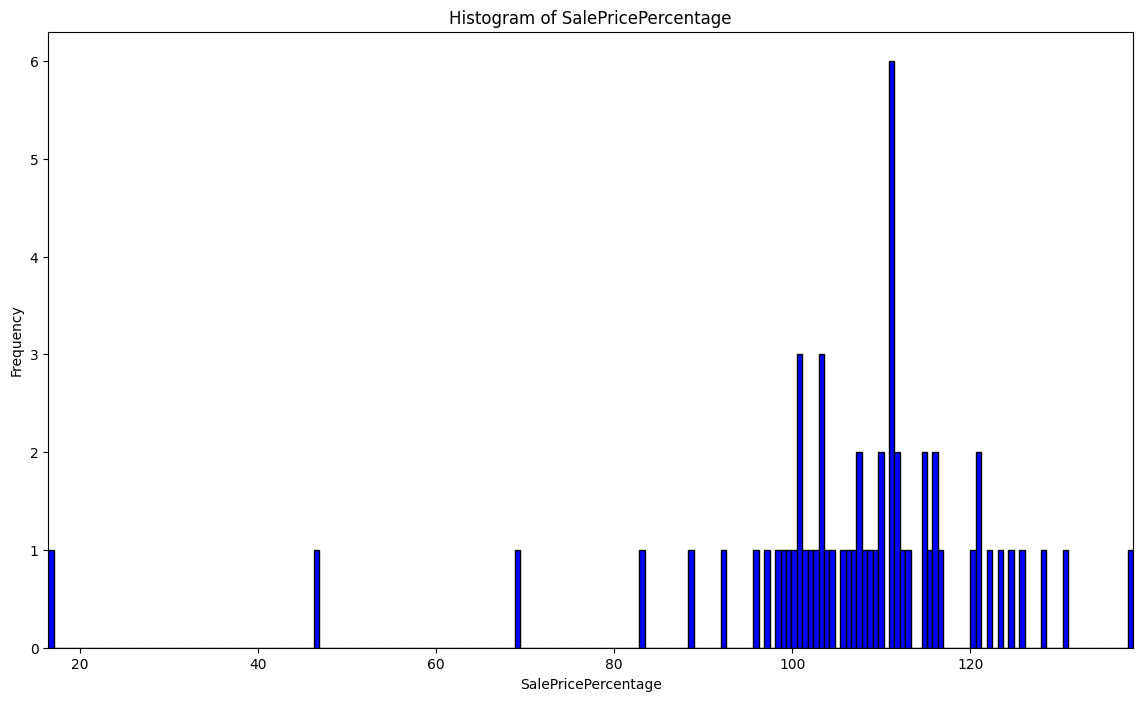

In [17]:
# looks like the SalePricePercentage is still the  best way to  remove this crummy data
items = items[items['SalePricePercentage']>10] # %10 seems to be a clean cut
plot_distribution_by_year(items,'SalePricePercentage')

In [18]:
print(items.head())

     PID   GISID  YearOfAssessment  AssessedValue  SalePrice  \
3    701   17-54              2021       969800.0   980000.0   
16   891   21-39              2021      1739100.0  1885000.0   
39  1075   23-74              2021       926900.0  1015000.0   
51  1174   24-39              2021       924700.0   844000.0   
79  1370  25-134              2021       820900.0   930000.0   

                          geometry                   Neighborhood_GlobalID  \
3   POINT (769343.345 2959224.195)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
16  POINT (769713.959 2960793.065)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
39  POINT (768418.323 2960495.175)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
51  POINT (769177.450 2959988.683)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   
79  POINT (768284.984 2960130.096)  {7FB4DD2D-34A9-48FE-BE3B-97270FA86326}   

    SalePricePercentage  Year  
3            101.051763  2018  
16           108.389397  2019  
39           109.504801  2018  
51            91.2

As we can see, this code is radically cleaner. Though there is potentially  more that could be done to clean the data, this should be sufficient for our purposes.

We now have a good amount of data divided by year. What I need to do is to calulate the average home price for each neighborhood for each year, and export each year as a map. That way we can compare on ArcGis between neighborhoods.

(93, 3)
       NAME                                GlobalID  \
0  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
1  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
2  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
3  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
4  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   

                                            geometry  \
0  POLYGON ((764653.313 2960781.500, 764672.187 2...   
1  POLYGON ((764653.313 2960781.500, 764672.187 2...   
2  POLYGON ((764653.313 2960781.500, 764672.187 2...   
3  POLYGON ((764653.313 2960781.500, 764672.187 2...   
4  POLYGON ((764653.313 2960781.500, 764672.187 2...   

                    Neighborhood_GlobalID    Year     SalePrice  
0  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2015.0  1.194821e+06  
1  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2016.0  1.100455e+06  
2  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2017.0  1.190947e+06  
3  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2018.0  1.524250e

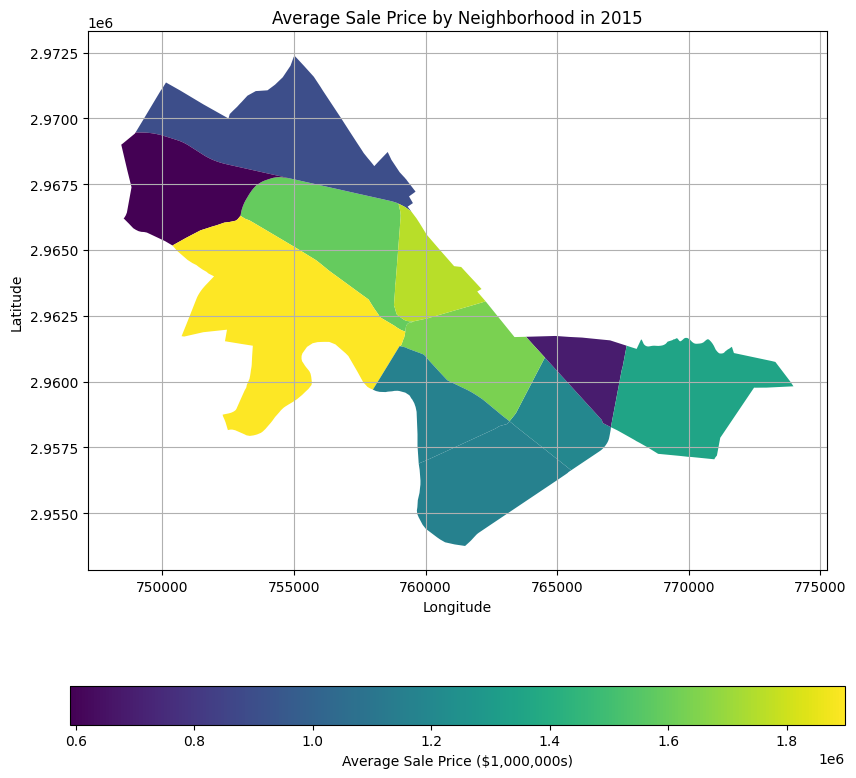

<Figure size 640x480 with 0 Axes>

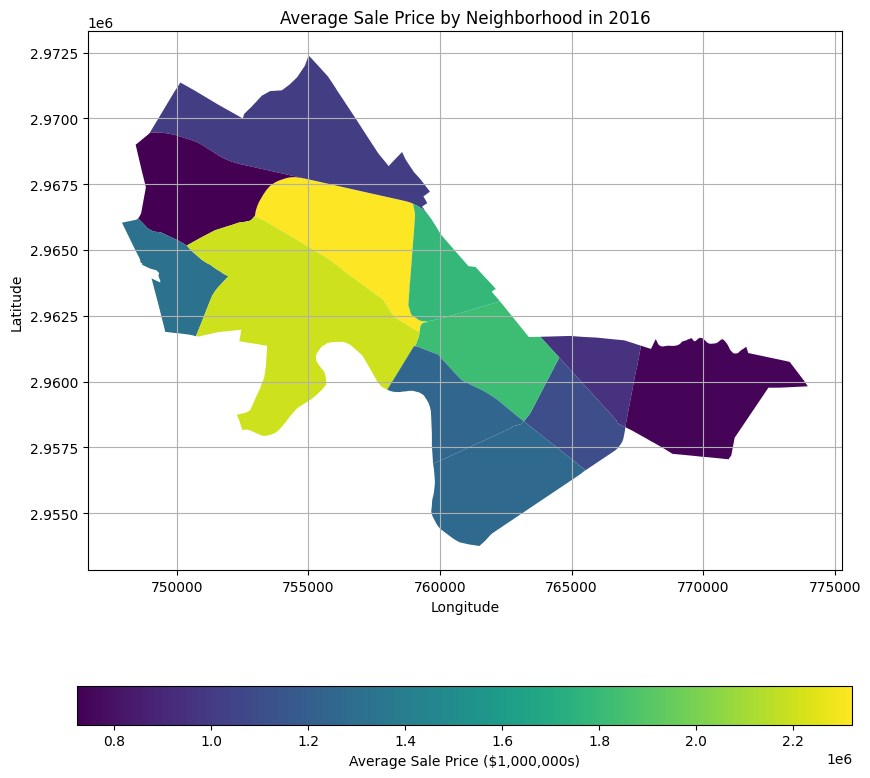

<Figure size 640x480 with 0 Axes>

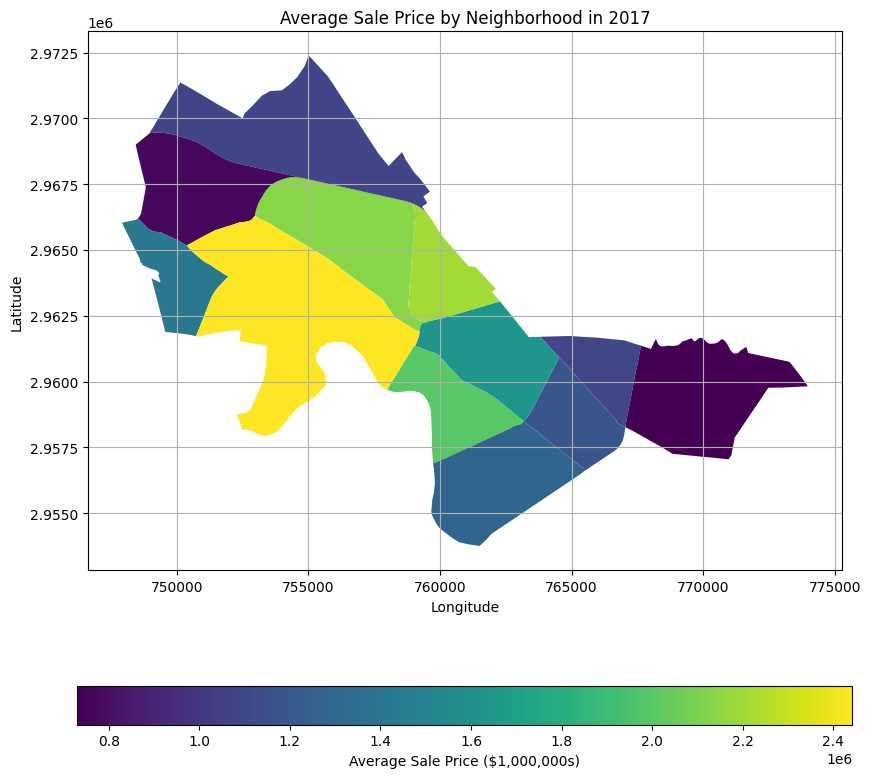

<Figure size 640x480 with 0 Axes>

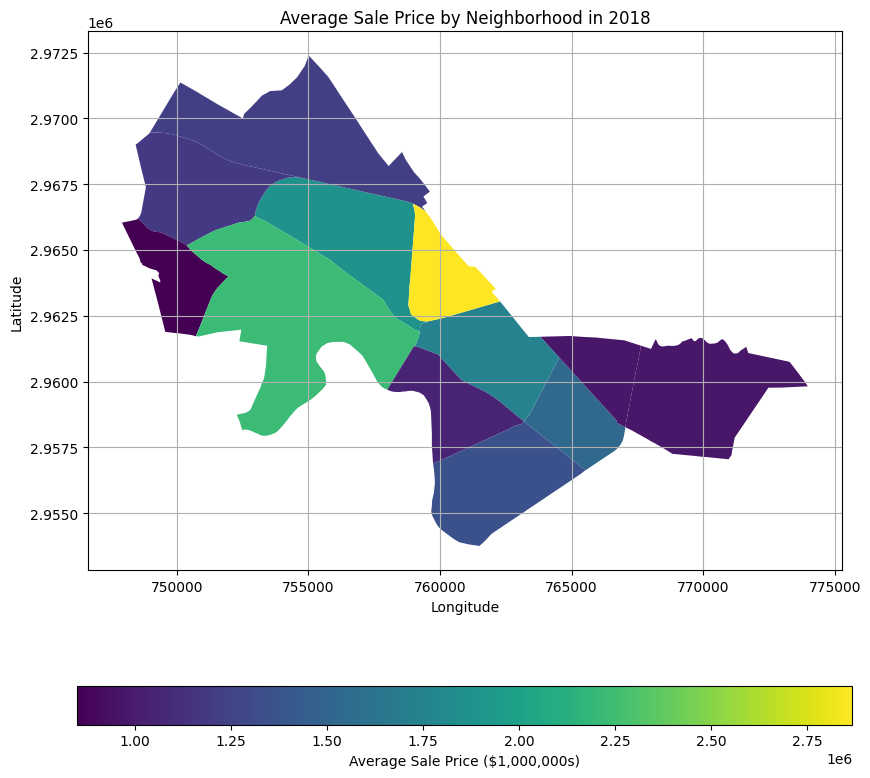

<Figure size 640x480 with 0 Axes>

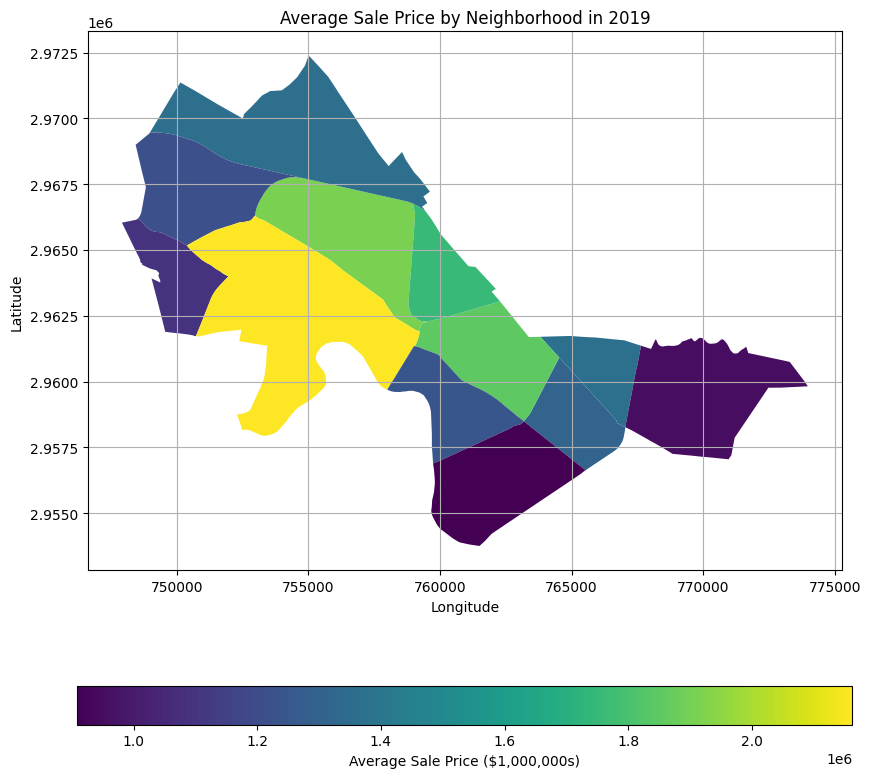

<Figure size 640x480 with 0 Axes>

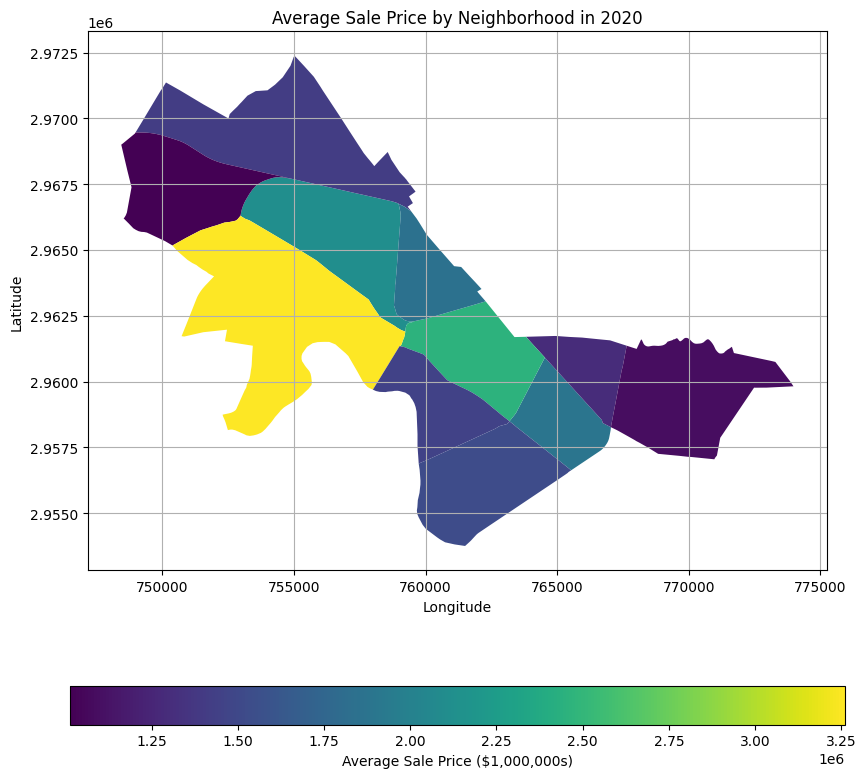

<Figure size 640x480 with 0 Axes>

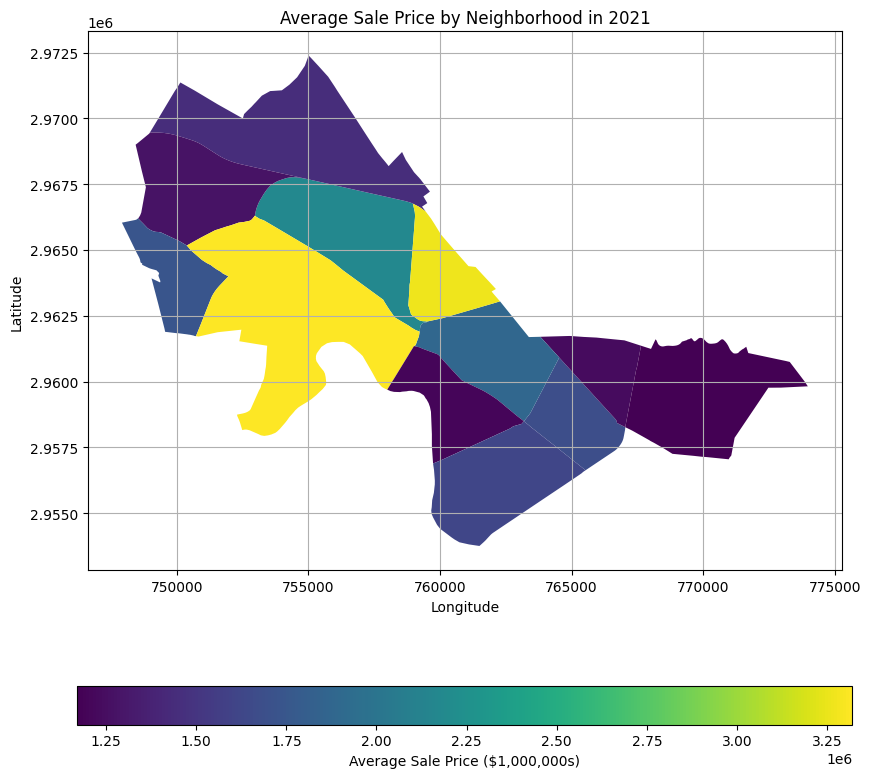

<Figure size 640x480 with 0 Axes>

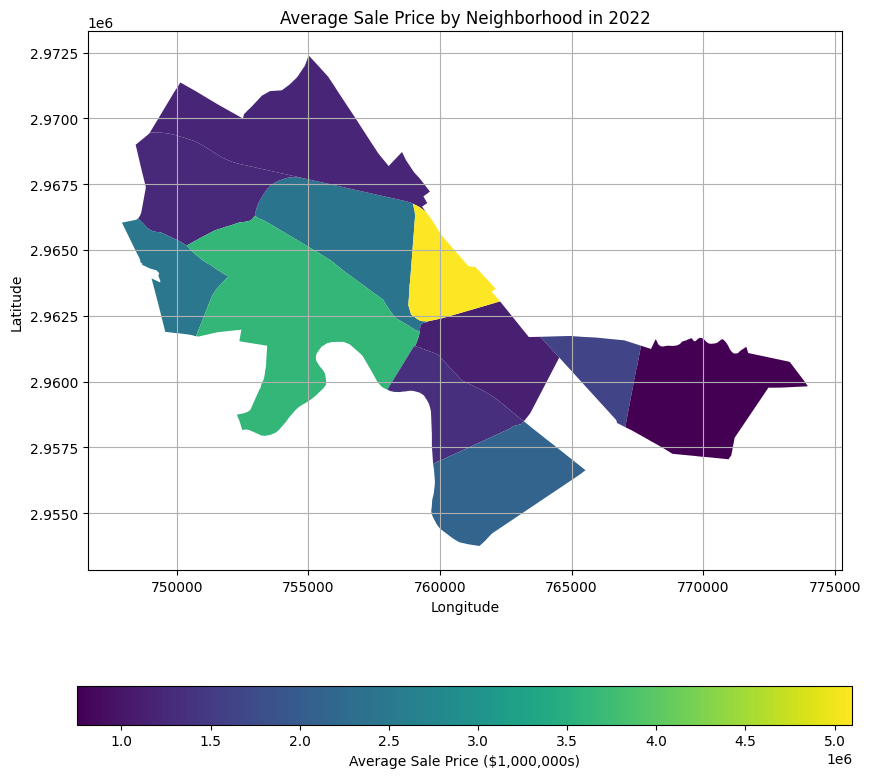

<Figure size 640x480 with 0 Axes>

In [19]:
def calculate_average_prices(data):
  temp = data.copy(deep=True)
  temp_n = neighborhoods.copy(deep = True)
  # Group data by Neighborhood and Year, then calculate the mean SalePrice
  if 'geometry' in data.columns:
    temp = temp.drop(columns=['geometry'])
  grouped_data = temp.groupby(['Neighborhood_GlobalID', 'Year']).agg({'SalePrice': 'mean'}).reset_index()
  print(grouped_data.shape)
  # Convert the result back to a GeoDataFrame
  result = pd.merge(temp_n,grouped_data,how='outer',left_on='GlobalID',right_on='Neighborhood_GlobalID')
  print(result.head())
  result_gdf = gpd.GeoDataFrame(result, geometry='geometry', crs=data.crs).drop(columns=['Neighborhood_GlobalID'])
  # Plotting and saving maps for each year
  years = result_gdf['Year'].unique()
  for year in years:
    try:
      year = int(year)
    except:
      continue
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    year_data = result_gdf[result_gdf['Year'] == year]

    # Plot each neighborhood with average sale prices
    year_data.plot(column='SalePrice', ax=ax, legend=True, legend_kwds={'label': "Average Sale Price ($1,000,000s)", 'orientation': "horizontal"})
    plt.title(f'Average Sale Price by Neighborhood in {int(year)}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
    # Save the figure to a file
    plt.savefig(f'average_sale_price_map_{year}.png')
    # plt.close()

calculate_average_prices(items)

(93, 3)
       NAME                                GlobalID  \
0  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
1  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
2  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
3  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
4  The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   

                                            geometry  \
0  POLYGON ((764653.313 2960781.500, 764672.187 2...   
1  POLYGON ((764653.313 2960781.500, 764672.187 2...   
2  POLYGON ((764653.313 2960781.500, 764672.187 2...   
3  POLYGON ((764653.313 2960781.500, 764672.187 2...   
4  POLYGON ((764653.313 2960781.500, 764672.187 2...   

                    Neighborhood_GlobalID    Year     SalePrice  
0  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2015.0  1.194821e+06  
1  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2016.0  1.100455e+06  
2  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2017.0  1.190947e+06  
3  {ED5E3360-A5DC-4A94-B1A2-56667062B754}  2018.0  1.524250e

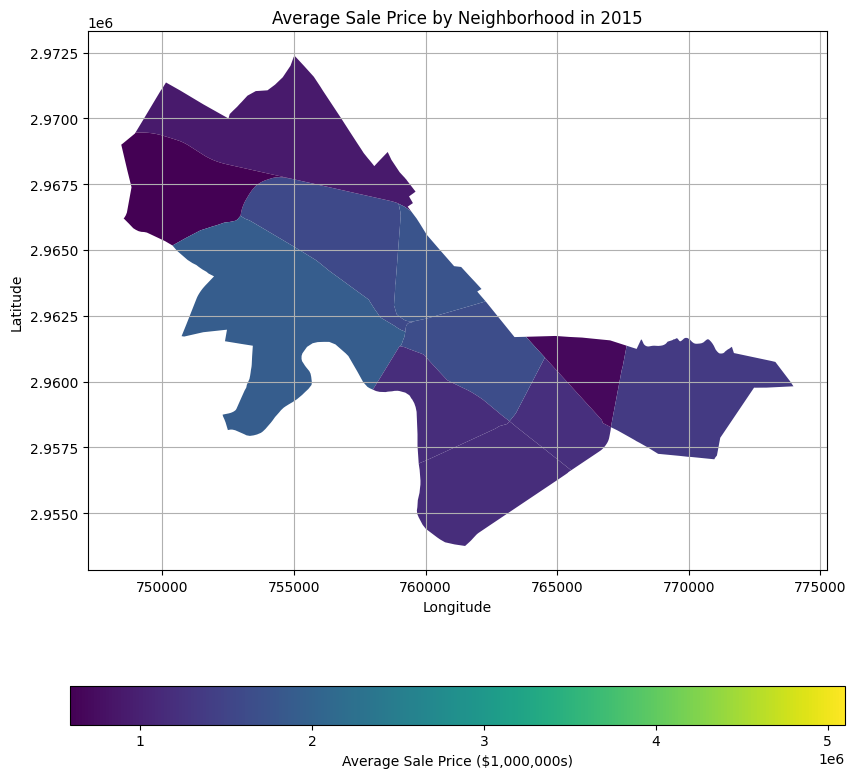

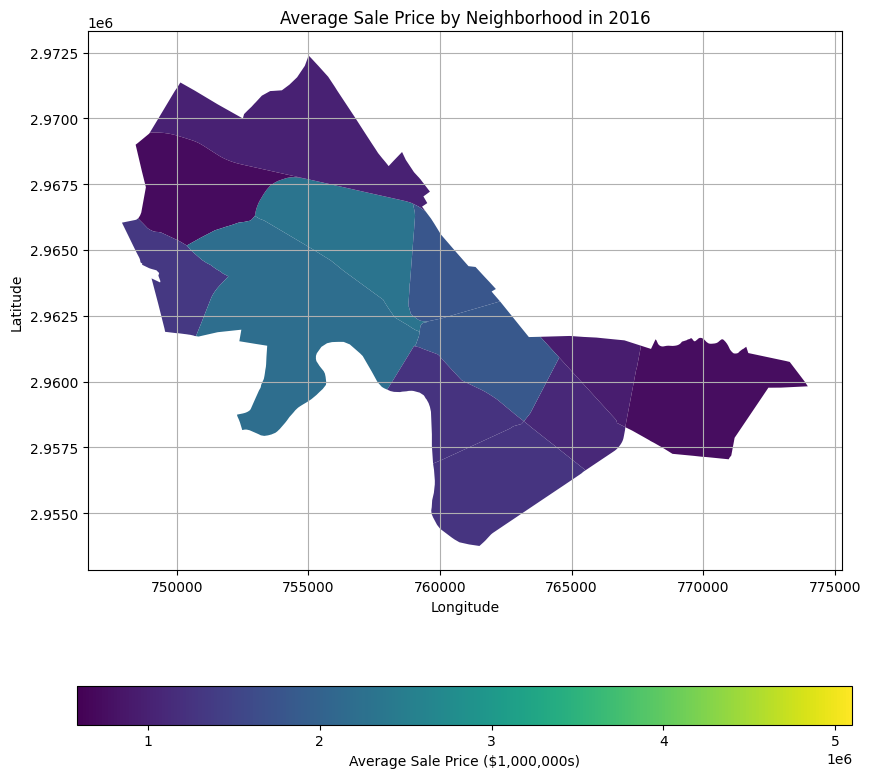

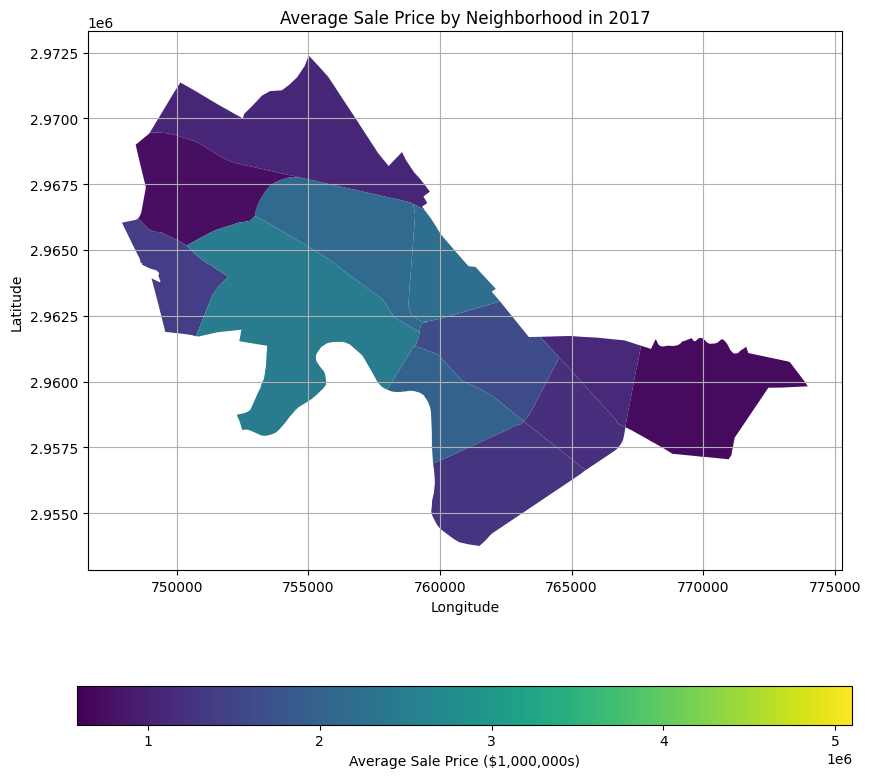

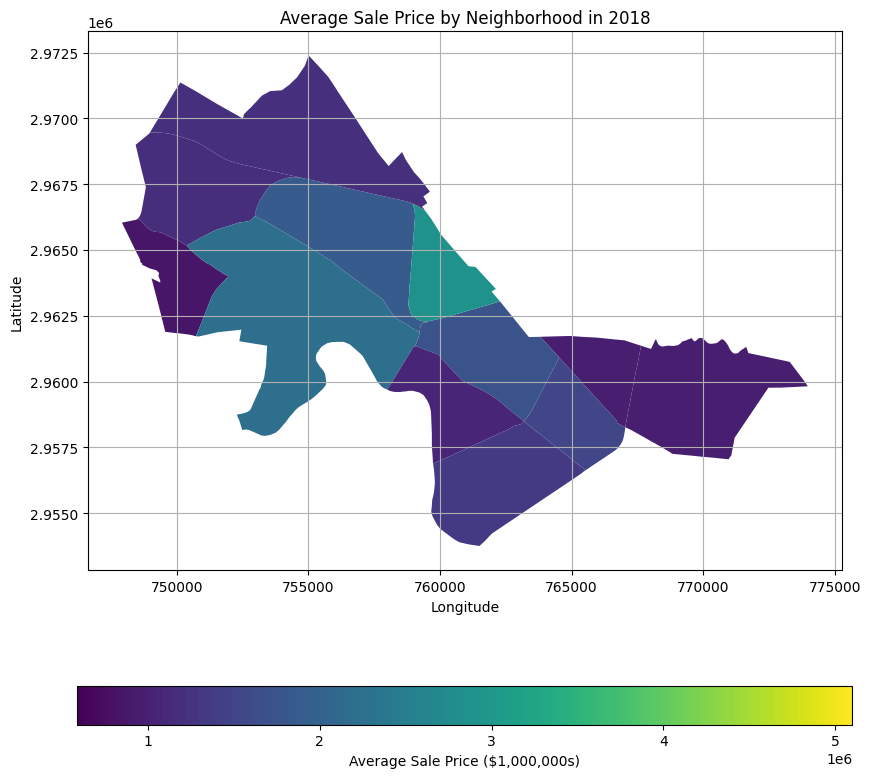

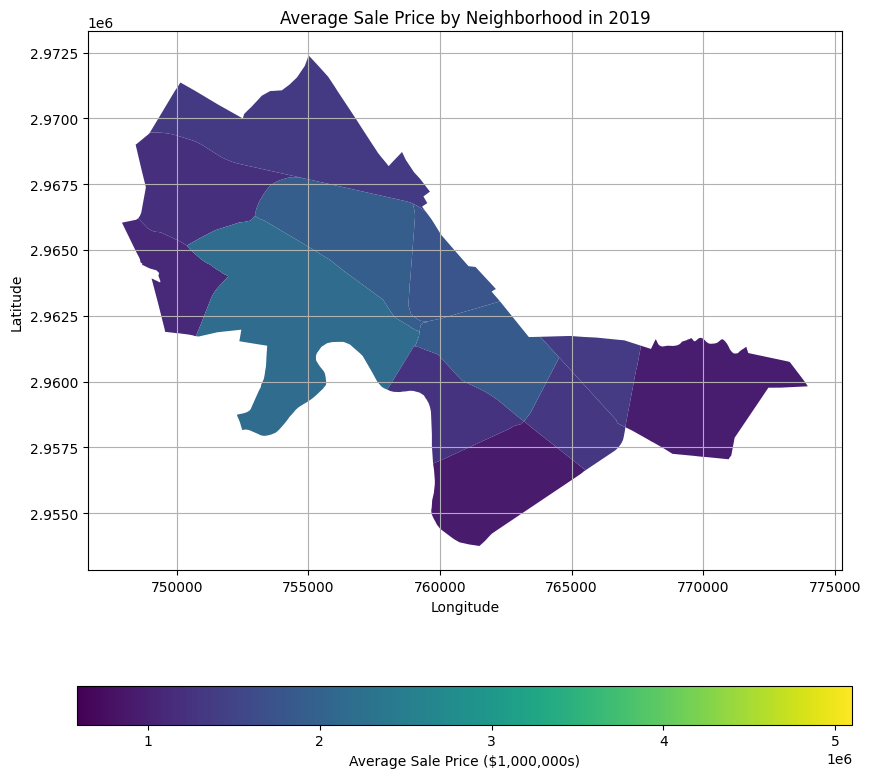

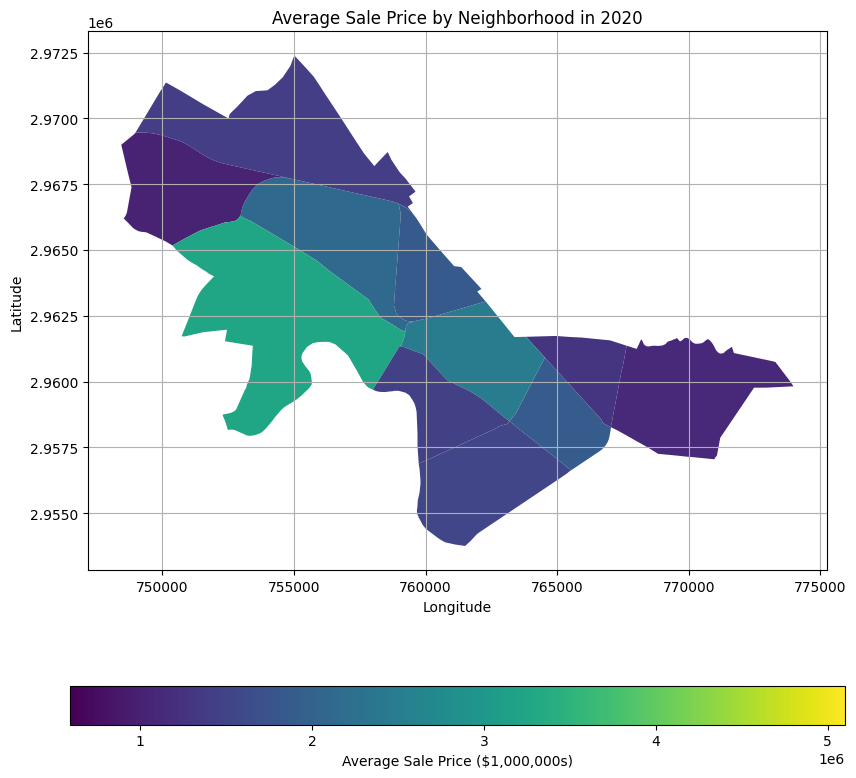

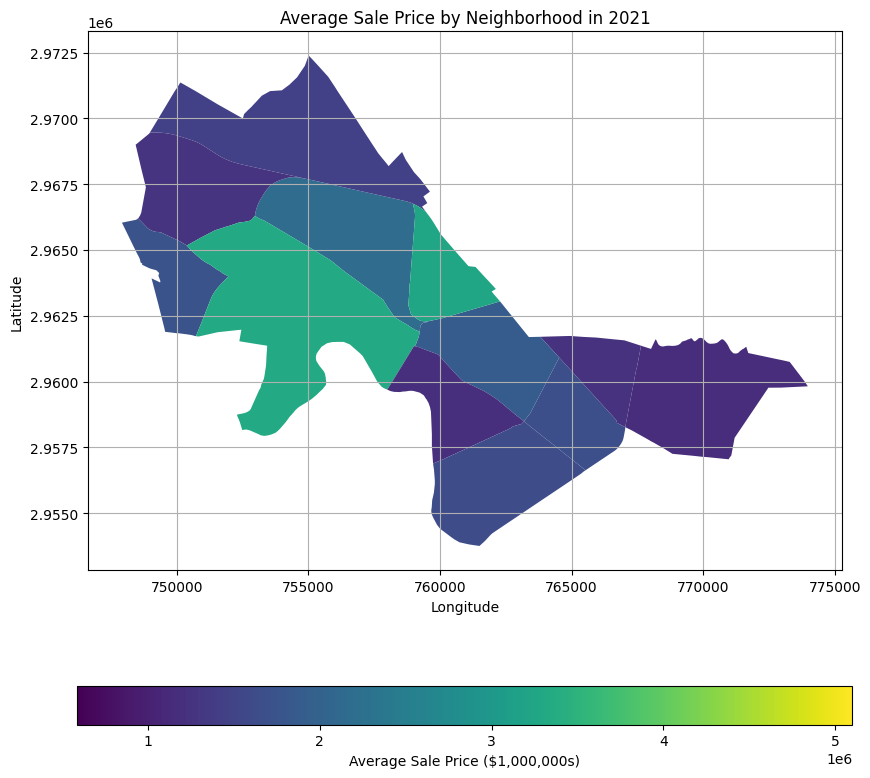

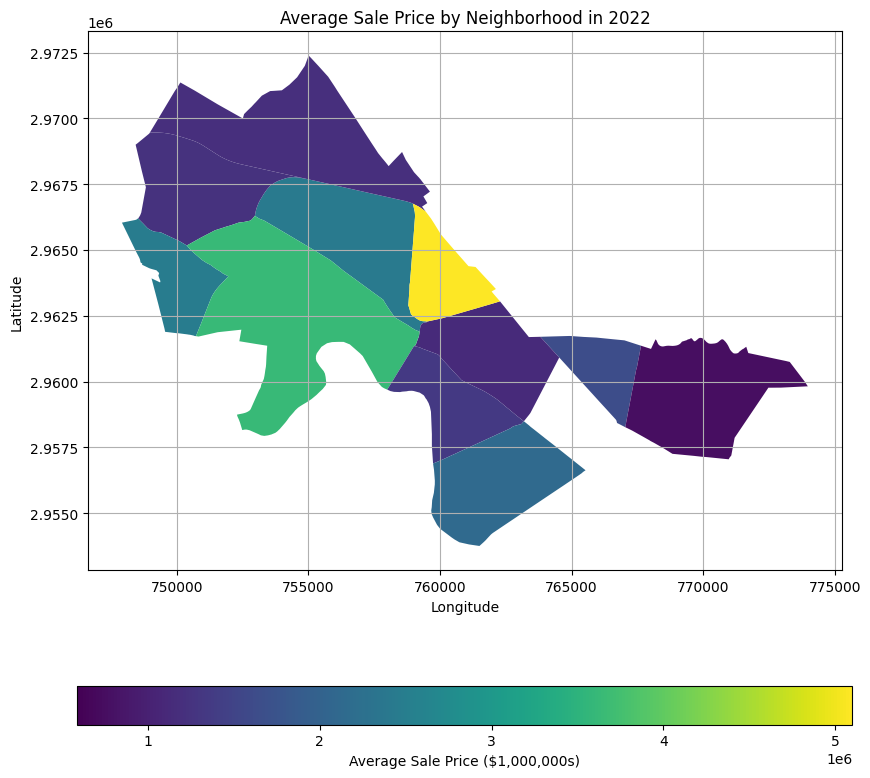

In [20]:
def calculate_average_prices(data, neighborhoods):
    temp = data.copy(deep=True)
    temp_n = neighborhoods.copy(deep=True)
    if 'geometry' in data.columns:
        temp = temp.drop(columns=['geometry'])
    grouped_data = temp.groupby(['Neighborhood_GlobalID', 'Year']).agg({'SalePrice': 'mean'}).reset_index()
    print(grouped_data.shape)
    result = pd.merge(temp_n, grouped_data, how='outer', left_on='GlobalID', right_on='Neighborhood_GlobalID')
    print(result.head())
    result_gdf = gpd.GeoDataFrame(result, geometry='geometry', crs=data.crs).drop(columns=['Neighborhood_GlobalID'])
    years = result_gdf['Year'].unique()

    vmin = result_gdf['SalePrice'].min()
    vmax = result_gdf['SalePrice'].max()

    for year in years:
        try:
            year = int(year)
        except:
            continue
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        year_data = result_gdf[result_gdf['Year'] == year]

        year_data.plot(column='SalePrice', ax=ax, legend=True, vmin=vmin, vmax=vmax,
                       legend_kwds={'label': "Average Sale Price ($1,000,000s)", 'orientation': "horizontal"})
        plt.title(f'Average Sale Price by Neighborhood in {year}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True)
        plt.show()
        plt.savefig(f'average_sale_price_map_{year}.png')
        plt.close()

calculate_average_prices(items, neighborhoods)

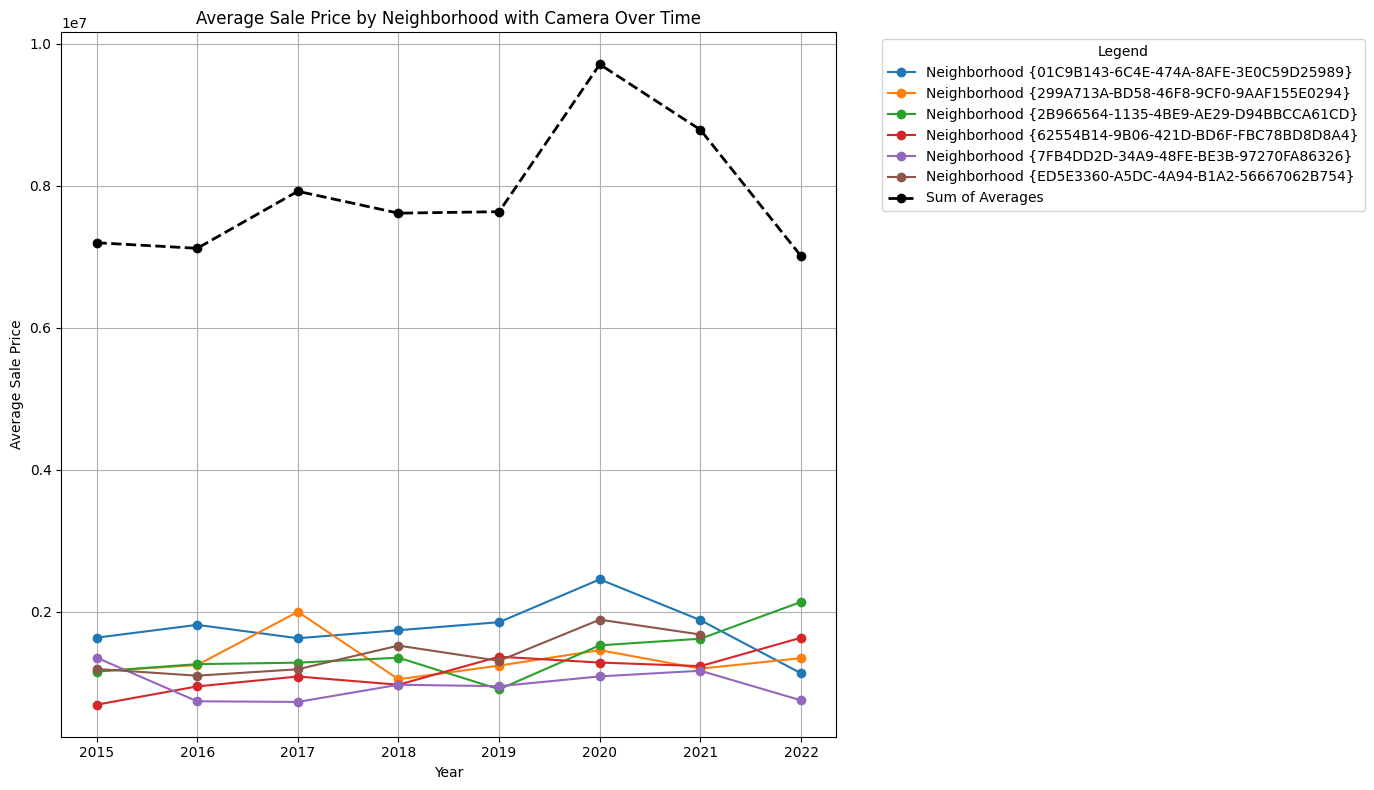

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_neighborhood_prices_over_time(cameras, neighborhoods, items):
    # Filter neighborhoods that have cameras
    camera_neighborhoods = cameras['Neighborhood_GlobalID'].unique()
    filtered_items = items[items['Neighborhood_GlobalID'].isin(camera_neighborhoods)]

    # Group by Year and Neighborhood and calculate the mean SalePrice
    yearly_prices = filtered_items.groupby(['Year', 'Neighborhood_GlobalID'])['SalePrice'].mean().reset_index()

    # Pivot data to have years as index and neighborhoods as columns with their average prices
    pivot_data = yearly_prices.pivot(index='Year', columns='Neighborhood_GlobalID', values='SalePrice')

    # Plotting
    plt.figure(figsize=(14, 8))
    for column in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[column], marker='o', label=f'Neighborhood {column}')

    # Sum of averages per year
    pivot_data['Sum of Averages'] = pivot_data.sum(axis=1)
    plt.plot(pivot_data.index, pivot_data['Sum of Averages'], marker='o', label='Sum of Averages', color='black', linewidth=2, linestyle='--')

    plt.title('Average Sale Price by Neighborhood with Camera Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Sale Price')
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_neighborhood_prices_over_time(cameras, neighborhoods, items)

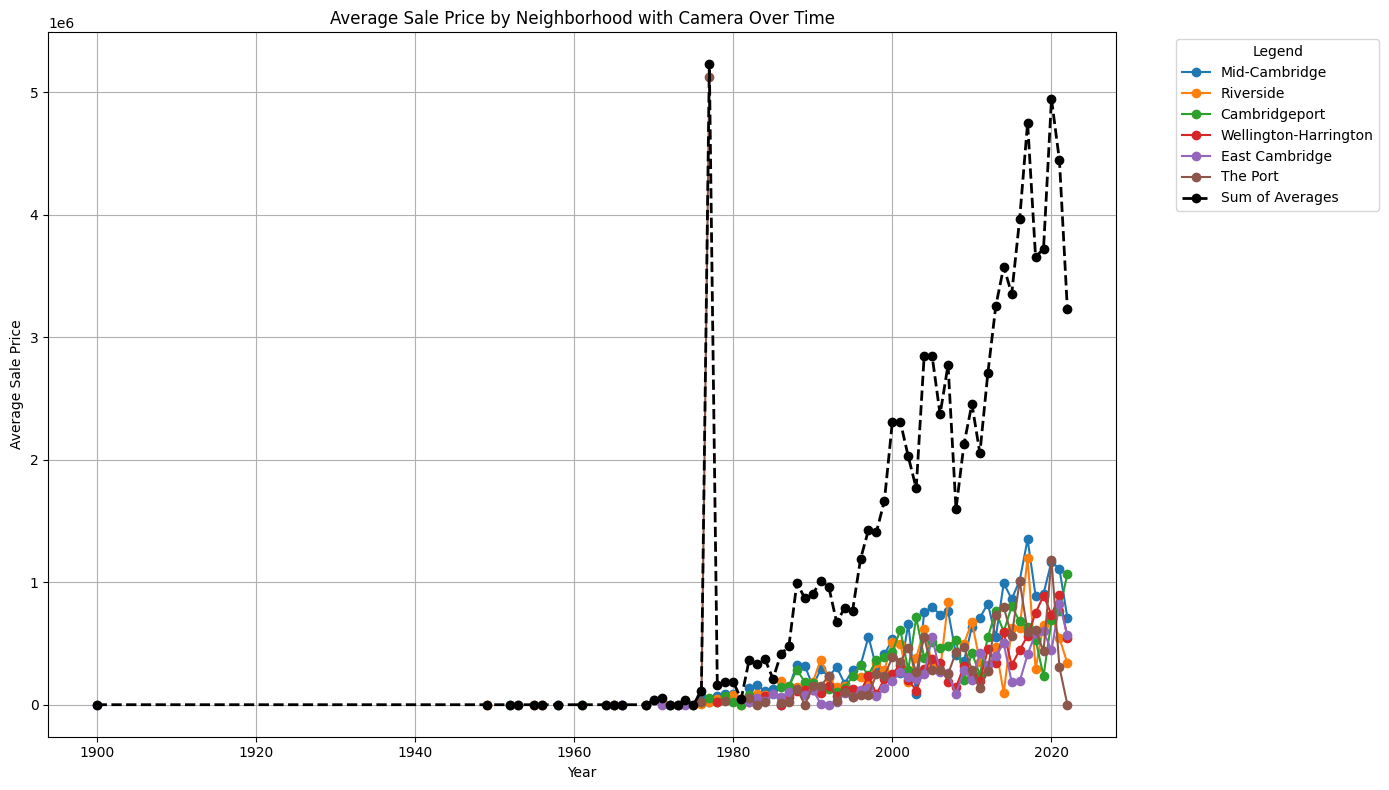

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_neighborhood_prices_over_time(cameras, neighborhoods, data):
    if 'Year' not in data:
      data['Year'] = pd.to_datetime(data['SaleDate']).dt.year
    # Create a mapping from Neighborhood_GlobalID to Name
    neighborhood_name_map = dict(zip(neighborhoods['GlobalID'], neighborhoods['NAME']))

    # Filter neighborhoods that have cameras
    camera_neighborhoods = cameras['Neighborhood_GlobalID'].unique()
    filtered_items = data[data['Neighborhood_GlobalID'].isin(camera_neighborhoods)]

    # Group by Year and Neighborhood and calculate the mean SalePrice
    yearly_prices = filtered_items.groupby(['Year', 'Neighborhood_GlobalID'])['SalePrice'].mean().reset_index()

    # Pivot data to have years as index and neighborhoods as columns with their average prices
    pivot_data = yearly_prices.pivot(index='Year', columns='Neighborhood_GlobalID', values='SalePrice')

    # Plotting
    plt.figure(figsize=(14, 8))
    for column in pivot_data.columns:
        # Use the name mapping for legend labels
        neighborhood_name = neighborhood_name_map.get(column, 'Unknown Neighborhood')
        plt.plot(pivot_data.index, pivot_data[column], marker='o', label=f'{neighborhood_name}')

    # Sum of averages per year
    pivot_data['Sum of Averages'] = pivot_data.sum(axis=1)
    plt.plot(pivot_data.index, pivot_data['Sum of Averages'], marker='o', label='Sum of Averages', color='black', linewidth=2, linestyle='--')

    plt.title('Average Sale Price by Neighborhood with Camera Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Sale Price')
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage

plot_neighborhood_prices_over_time(cameras, neighborhoods, assessment_items)


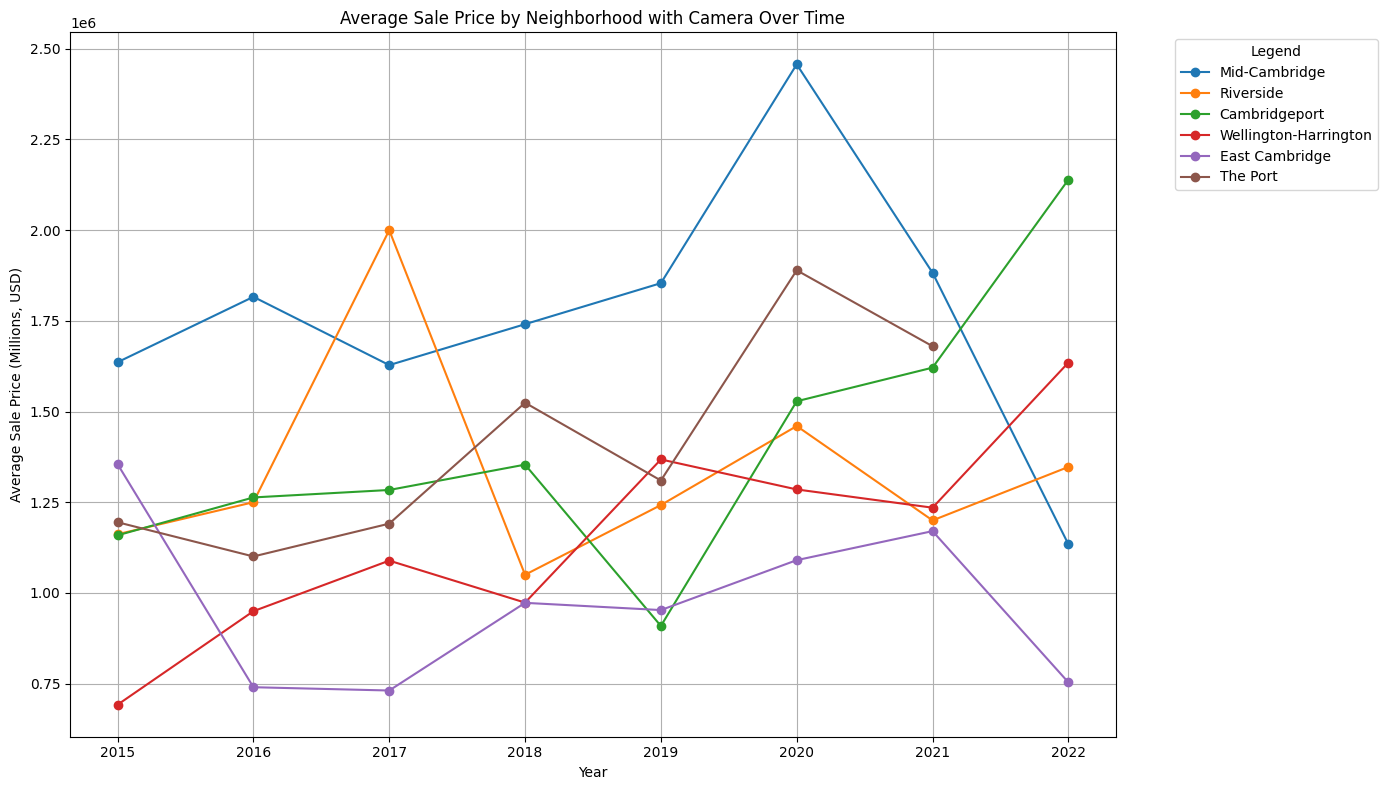

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_neighborhood_prices_over_time(cameras, neighborhoods, items, min_year=None, max_year=None):
    # Create a mapping from Neighborhood_GlobalID to Name
    neighborhood_name_map = dict(zip(neighborhoods['GlobalID'], neighborhoods['NAME']))

    # Filter neighborhoods that have cameras
    camera_neighborhoods = cameras['Neighborhood_GlobalID'].unique()
    filtered_items = items[items['Neighborhood_GlobalID'].isin(camera_neighborhoods)]

    # Group by Year and Neighborhood and calculate the mean SalePrice
    yearly_prices = filtered_items.groupby(['Year', 'Neighborhood_GlobalID'])['SalePrice'].mean().reset_index()

    # Apply year filter if specified
    if min_year is not None:
        yearly_prices = yearly_prices[yearly_prices['Year'] >= min_year]
    if max_year is not None:
        yearly_prices = yearly_prices[yearly_prices['Year'] <= max_year]

    # Pivot data to have years as index and neighborhoods as columns with their average prices
    pivot_data = yearly_prices.pivot(index='Year', columns='Neighborhood_GlobalID', values='SalePrice')

    # Plotting
    plt.figure(figsize=(14, 8))
    for column in pivot_data.columns:
        # Use the name mapping for legend labels
        neighborhood_name = neighborhood_name_map.get(column, 'Unknown Neighborhood')
        plt.plot(pivot_data.index, pivot_data[column], marker='o', label=f'{neighborhood_name}')

    # Sum of averages per year
    pivot_data['Sum of Averages'] = pivot_data.sum(axis=1)
    # plt.plot(pivot_data.index, pivot_data['Sum of Averages'], marker='o', label='Sum of Averages', color='black', linewidth=2, linestyle='--')

    plt.title('Average Sale Price by Neighborhood with Camera Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Sale Price (Millions, USD)')
    # plt.yscale('log')  # Set the y-axis to a logarithmic scale
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage, assuming you have set the dataframes `cameras`, `neighborhoods`, and `items`
plot_neighborhood_prices_over_time(cameras, neighborhoods, items, min_year=2015, max_year=2022)


In [24]:
# now I need to fit gaussians to the items
import pandas as pd
import geopandas as gpd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

def fit_gaussian_mixture(data, n_components=2):
    results = {}
    grouped = data.groupby(['Neighborhood_GlobalID', 'Year'])
    for (neighborhood, year), group in grouped:
        X = group['SalePricePercentage'].values.reshape(-1, 1)

        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(X)

        results[(neighborhood, year)] = {
            'model': gmm,
            'means': gmm.means_.flatten(),
            'covariances': gmm.covariances_.flatten(),
            'weights': gmm.weights_.flatten()
        }

        plt.figure(figsize=(10, 6))
        x = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
        logprob = gmm.score_samples(x)
        pdf = np.exp(logprob)
        pdf_individual = gmm.weights_[:, np.newaxis] * np.exp(gmm._estimate_log_prob(x))

        plt.hist(X, bins=20, density=True, alpha=0.5, color='gray')
        plt.plot(x, pdf, '-k')
        plt.plot(x, pdf_individual, '--r')
        plt.title(f'Gaussian Mixture for {neighborhood}, {year}')
        plt.xlabel('SalePricePercentage')
        plt.ylabel('Density')
        plt.show()

    return results

results = fit_gaussian_mixture(items)


ValueError: operands could not be broadcast together with shapes (2,1) (1000,2) 

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
import geopandas as gpd
from sklearn.mixture import GaussianMixture
import numpy as np

def fit_gaussian_mixtures(data):
    """
    Fits Gaussian mixture models to SalePricePercentage for each neighborhood and year.

    Args:
    data (gpd.GeoDataFrame): GeoDataFrame with 'Neighborhood_GlobalID', 'Year', and 'SalePricePercentage'.

    Returns:
    dict: A dictionary with keys as (Neighborhood_GlobalID, Year) and values as GaussianMixture models.
    """
    # Dictionary to store the models
    gmm_dict = {}

    # Group data by Neighborhood_GlobalID and Year
    grouped = data.groupby(['Neighborhood_GlobalID', 'Year'])

    # Iterate over each group
    for (neighborhood, year), group in grouped:
        # Reshape data for fitting
        X = group['SalePricePercentage'].values.reshape(-1, 1)

        # Fit a Gaussian Mixture Model
        # You can adjust n_components based on your specific data and needs
        gmm = GaussianMixture(n_components=1, random_state=0)
        try:
          gmm.fit(X)
        except: continue
        # Store the model in the dictionary
        gmm_dict[(neighborhood, year)] = gmm

    return gmm_dict

# Example usage:
# Assuming 'assessment_items' is already loaded and contains the necessary columns
models = fit_gaussian_mixtures(items)
# Now models is a dictionary where you can access a model using a (Neighborhood_GlobalID, Year) key


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

def plot_gaussian_with_data(data, gmm):
    """
    Plots the data along with the Gaussian mixture model's PDF.

    Args:
    data (np.array): An array of data points.
    gmm (GaussianMixture): A fitted GaussianMixture model.
    """
    # Create figure and axis
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Plot histogram of the data
    ax.hist(data, bins=100, density=True, alpha=0.6, color='blue', label='Sale Price Histogram')

    # Create an array of values for plotting the PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf = np.zeros_like(x)

    # Sum the PDFs of each Gaussian component
    for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        pdf += weight * norm.pdf(x, mean[0], np.sqrt(covar[0][0]))

    # Plot the PDF
    ax.plot(x, pdf, 'r-', label='Gaussian Mixture')

    # Adding labels and legend
    plt.xlabel('Sale Price Percentage (%)')
    plt.ylabel('Density / Frequency')
    plt.title('Fit of Gaussian Mixture Model to Sale Price Histogram (All of Cambridge)')
    plt.legend()

    # Show plot
    plt.show()

# Example usage:
# Assuming you have some data and a fitted model
data_points = items['SalePricePercentage'].values
gmm_model = GaussianMixture(n_components=1, random_state=0)
gmm_model.fit(data_points.reshape(-1, 1))
plot_gaussian_with_data(data_points, gmm_model)


In [ ]:
plot_raw_frequency(items,'SalePricePercentage',)

# Remember to upload to GitHub when done!